![qqq](../resources/header.jpg)

**Машинное обучение**
***

О сайте **VGChartz.com**:

"Компания **VGChartz (Video Game Charts)**, основанная в 2005 году Бреттом Уолтоном, является фирмой по бизнес-аналитике и исследованиям, а также издателем веб-сайтов **VGChartz.com**. Как отраслевая исследовательская фирма, VGChartz каждую неделю публикует оценки оборудования для видеоигр и размещает постоянно расширяющуюся базу данных игр, в которой содержится более 55 000 наименований, содержащая актуальную информацию о поставках и устаревшие данные о продажах. Веб-сайт VGChartz.com предоставляет потребителям разнообразный контент: от новостей и продаж до обзоров и статей, социальных сетей и форумов сообщества". - с сайта **[VGChartz.com](https://www.vgchartz.com)**.

**Методология сбора данных**:
С конца 2018 года VGChartz больше не составляет оценки продаж программного обеспечения. Это связано с тем, что высокая доля цифрового рынка программного обеспечения затрудняла получение надежных розничных оценок, а также делала эти оценки все более нерепрезентативными для более широкой производительности рассматриваемых игр. В результате, что касается программного обеспечения, мы теперь записываем только официальные данные об отгрузках/продажах, если такие данные предоставляются разработчиками и издателями. Устаревшие данные остаются на сайте для тех, кто заинтересован в их просмотре.- с сайта **[VGChartz.com](https://www.vgchartz.com)**.

**Цель машинного обучения**: на основе подготовленных и предварительно обработанных исторических данных, обучить модель, предсказывающую количество проданных копий видеоигры.

**Этапы машинного обучения**:
1. [Обзор данных](#Обзор-данных).
2. [Предобработка данных](#Предобработка-данных)
3. [Машинное обучение](#Машинное-обучение):
    - [Отбор данных](#Отбор-данных);
    - [Преобразование данных](#Преобразование-данных);
    - [Разделение на выборки](#Разделение-на-выборки)
    - [Тестирование моделей](#Тестирование-моделей)
        - [Тестирование DecisionTreeRegressor](#Тестирование-DecisionTreeRegressor)
        - [Тестирование RandomForestRegressor](#Тестирование-RandomForestRegressor)
        - [Тестирование HistGradientBoostingRegressor](#Тестирование-HistGradientBoostingRegressor)
        - [Тестирование LGBMRegressor](#Тестирование-LGBMRegressor)
        - [Тестирование XGBRegressor](#Тестирование-XGBRegressor)
        - [Выводы по тестированию моделей](#Выводы-по-тестированию-моделей)
    - [Генерация признаков](#Генерация-признаков)
        - [DecisionTreeRegressor](#DecisionTreeRegressor)
        - [RandomForestRegressor](#RandomForestRegressor)
        - [HistGradientBoostingRegressor](#HistGradientBoostingRegressor)
        - [LGBMRegressor](#LGBMRegressor)
        - [XGBRegressor](#XGBRegressor)
        - [Выводы по генерации признаков](#Выводы-по-генерации-признаков)
    - [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке).
    - [Сравнение с фиктивным регрессором](#Сравнение-с-фиктивным-регрессором).
4. [Выводы](#Выводы)
***

In [1]:
import sys

In [2]:
sys.path.append('C:\Projects\VGChartz')
sys.path.append('C:\Projects\VGChartz\src')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from config.ml import FIT_CV_N_SPLITS
from config.ml import FIT_CV_TEST_SIZE
from config.ml import FIT_CV_VERBOSE
from config.ml import LEARNING_CURVE_N_SPLITS
from config.ml import LEARNING_CURVE_TEST_SIZE
from config.ml import LEARNING_CURVE_TRAIN_SIZES
from config.ml import LEARNING_CURVE_VERBOSE
from config.ml import N_JOBS
from config.ml import RANDOM_STATE
from config.ml import TEST_SIZE
from config.paths import FILE_PREPROCESSED_PATH
from utils.explorer import explorer
from utils.ml.features import generate
from utils.ml.plot import error
from utils.ml.plot import scalability


In [4]:
sns.set_style('white')

In [5]:
print(explorer(FILE_PREPROCESSED_PATH, '*.csv'))

1. vgchartz.csv.


In [6]:
FILE_PATH = FILE_PREPROCESSED_PATH + r'\vgchartz.csv'

# Обзор данных
***

In [7]:
df = pd.read_csv(FILE_PATH)

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60887 entries, 0 to 60886
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       60887 non-null  object 
 1   date       54735 non-null  object 
 2   platform   60887 non-null  object 
 3   publisher  52865 non-null  object 
 4   developer  56442 non-null  object 
 5   shipped    2903 non-null   float64
 6   total      18919 non-null  float64
 7   america    12637 non-null  float64
 8   europe     12824 non-null  float64
 9   japan      6723 non-null   float64
 10  other      15128 non-null  float64
 11  vgc        2142 non-null   float64
 12  critic     6615 non-null   float64
 13  user       404 non-null    float64
dtypes: float64(9), object(5)
memory usage: 23.6 MB


In [9]:
df.head()

name        date platform publisher  \
0                        Wii Sports  2006-11-19      Wii  Nintendo   
1               Mario Kart 8 Deluxe  2017-04-28       NS  Nintendo   
2     Animal Crossing: New Horizons  2020-03-20       NS  Nintendo   
3                 Super Mario Bros.  1985-10-18      NES  Nintendo   
4  Counter-Strike: Global Offensive  2012-08-21       PC     Valve   

           developer  shipped  total  america  europe  japan  other  vgc  \
0       Nintendo EAD    82.90    NaN      NaN     NaN    NaN    NaN  NaN   
1       Nintendo EPD    57.01    NaN      NaN     NaN    NaN    NaN  NaN   
2           Nintendo    43.38    NaN      NaN     NaN    NaN    NaN  8.0   
3       Nintendo EAD    40.24    NaN      NaN     NaN    NaN    NaN  NaN   
4  Valve Corporation    40.00    NaN      NaN     NaN    NaN    NaN  NaN   

   critic  user  
0     7.7   NaN  
1     9.3   NaN  
2     NaN   NaN  
3    10.0   8.2  
4     NaN   NaN

In [10]:
df.sample(5)

name        date platform          publisher  \
34964                          Jacked         NaN      PS2                NaN   
40068     Nobunaga no Yabou: Ranseiki  2002-02-22       XB               KOEI   
33144                       GT Racing  1996-03-29     SNES          Imagineer   
52590  Yumsters! 2: Around the World!  2008-07-23       PC  KranX Productions   
4618            Skylanders: Trap Team  2014-10-05      PS4         Activision   

                       developer  shipped  total  america  europe  japan  \
34964  Sproing Interactive Media      NaN    NaN      NaN     NaN    NaN   
40068                       Koei      NaN    NaN      NaN     NaN    NaN   
33144                  Imagineer      NaN    NaN      NaN     NaN    NaN   
52590          KranX Productions      NaN    NaN      NaN     NaN    NaN   
4618                Toys for Bob      NaN   0.52     0.25    0.18    NaN   

       other  vgc  critic  user  
34964    NaN  NaN     NaN   NaN  
40068    NaN  NaN     NaN   NaN  
33144    NaN  NaN     NaN   NaN  
52590    NaN  NaN     NaN   NaN  
4618    0.09  NaN     NaN   NaN

In [11]:
df.tail()

name        date platform  \
60882  The Elder Scrolls Online: Tamriel Unlimited  2015-06-09       PC   
60883     The Elder Scrolls V: Skyrim - Dragonborn         NaN     X360   
60884     The Elder Scrolls V: Skyrim - Dragonborn         NaN      PS3   
60885     The Elder Scrolls V: Skyrim - Dragonborn         NaN       PC   
60886     The Elder Scrolls V: Skyrim - Hearthfire         NaN       XS   

                publisher               developer  shipped  total  america  \
60882  Bethesda Softworks  ZeniMax Online Studios      NaN    NaN      NaN   
60883                 NaN      Bethesda Softworks      NaN    NaN      NaN   
60884                 NaN      Bethesda Softworks      NaN    NaN      NaN   
60885                 NaN      Bethesda Softworks      NaN    NaN      NaN   
60886                 NaN   Bethesda Game Studios      NaN    NaN      NaN   

       europe  japan  other  vgc  critic  user  
60882     NaN    NaN    NaN  NaN     NaN   NaN  
60883     NaN    NaN    NaN  8.6     NaN   NaN  
60884     NaN    NaN    NaN  NaN     NaN   NaN  
60885     NaN    NaN    NaN  NaN     NaN   NaN  
60886     NaN    NaN    NaN  NaN     NaN   NaN

# Предобработка данных

In [12]:
df.dtypes

name          object
date          object
platform      object
publisher     object
developer     object
shipped      float64
total        float64
america      float64
europe       float64
japan        float64
other        float64
vgc          float64
critic       float64
user         float64
dtype: object

Изменим типы данных:
- для поля **date** изменим тип данных на **datetime**;
- для **числовых полей**, уменьшим точность до **32 бит**.

In [13]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [14]:
df = df.astype({
    'shipped': 'float32',
    'total': 'float32',
    'america': 'float32',
    'europe': 'float32',
    'japan': 'float32',
    'other': 'float32',
    'vgc': 'float32',
    'critic': 'float32',
    'user': 'float32',
})

In [15]:
df.dtypes

name                 object
date         datetime64[ns]
platform             object
publisher            object
developer            object
shipped             float32
total               float32
america             float32
europe              float32
japan               float32
other               float32
vgc                 float32
critic              float32
user                float32
dtype: object

# Машинное обучение
***

## Отбор данных
***

In [16]:
df.head()

name       date platform publisher  \
0                        Wii Sports 2006-11-19      Wii  Nintendo   
1               Mario Kart 8 Deluxe 2017-04-28       NS  Nintendo   
2     Animal Crossing: New Horizons 2020-03-20       NS  Nintendo   
3                 Super Mario Bros. 1985-10-18      NES  Nintendo   
4  Counter-Strike: Global Offensive 2012-08-21       PC     Valve   

           developer    shipped  total  america  europe  japan  other  vgc  \
0       Nintendo EAD  82.900002    NaN      NaN     NaN    NaN    NaN  NaN   
1       Nintendo EPD  57.009998    NaN      NaN     NaN    NaN    NaN  NaN   
2           Nintendo  43.380001    NaN      NaN     NaN    NaN    NaN  8.0   
3       Nintendo EAD  40.240002    NaN      NaN     NaN    NaN    NaN  NaN   
4  Valve Corporation  40.000000    NaN      NaN     NaN    NaN    NaN  NaN   

   critic  user  
0     7.7   NaN  
1     9.3   NaN  
2     NaN   NaN  
3    10.0   8.2  
4     NaN   NaN

Отберем только те данные, которые содержат записи в полях **date**, **platform**, **publisher**, **developer** и **total**. В качестве дополнительных данных возмем поля **america**, **europe**, **japan** и **other**.

In [17]:
columns = ['date', 'platform', 'publisher', 'developer', 'total']
data = df[(df[columns].notna().all(axis=1)) & (df['total'] < 1.0) ]

In [18]:
data

name       date platform  \
2671                      NFL Fever 2002 2001-11-14       XB   
2672                                Haze 2008-05-20      PS3   
2673             The Simpsons: Hit & Run 2003-09-16       GC   
2674             Oddworld: Abe's Exoddus 1998-11-17       PS   
2675                   Tales of Graces f 2012-03-13      PS3   
...                                  ...        ...      ...   
21817       Mind, Body & Soul: Blend It! 2010-04-23       DS   
21818              Ride! Carnival Tycoon 2007-08-01       PC   
21819      Shinobido: Tales of the Ninja 2007-02-09      PSP   
21820    Tactical Ops: Assault on Terror 2002-04-24       PC   
21821  World in Conflict: Soviet Assault 2009-03-10       PC   

                         publisher                                  developer  \
2671                     Microsoft                                  Microsoft   
2672                       Ubisoft                        Free Radical Design   
2673                      VU Games                      Radical Entertainment   
2674                GT Interactive                        Oddworld Inhabitans   
2675                  Namco Bandai                         Namco Tales Studio   
...                            ...                                        ...   
21817                    505 Games                              Crush Digital   
21818                     ValuSoft                                   ValuSoft   
21819  Sony Computer Entertainment                                    Acquire   
21820                        Atari                            Kamehan Studios   
21821                      Ubisoft  Massive Entertainment / Swordfish Studios   

       shipped  total  america  europe  japan  other  vgc  critic  user  
2671       NaN   0.99     0.74    0.21    NaN   0.04  NaN     NaN   NaN  
2672       NaN   0.99     0.49    0.33   0.02   0.15  NaN     5.6   NaN  
2673       NaN   0.99     0.77    0.20    NaN   0.03  NaN     8.2   NaN  
2674       NaN   0.99     0.55    0.38    NaN   0.06  NaN     8.6   NaN  
2675       NaN   0.99     0.28    0.19   0.45   0.07  8.0     NaN   8.0  
...        ...    ...      ...     ...    ...    ...  ...     ...   ...  
21817      NaN   0.00      NaN    0.00    NaN    NaN  NaN     NaN   NaN  
21818      NaN   0.00      NaN    0.00    NaN    NaN  NaN     NaN   NaN  
21819      NaN   0.00      NaN    0.00    NaN    NaN  NaN     NaN   NaN  
21820      NaN   0.00      NaN    0.00    NaN    NaN  NaN     NaN   NaN  
21821      NaN   0.00      NaN    0.00    NaN    NaN  NaN     6.1   NaN  

[16788 rows x 14 columns]

In [19]:
countries = ['america', 'europe', 'japan', 'other']
data = data[columns + countries]

In [20]:
data

date platform                    publisher  \
2671  2001-11-14       XB                    Microsoft   
2672  2008-05-20      PS3                      Ubisoft   
2673  2003-09-16       GC                     VU Games   
2674  1998-11-17       PS               GT Interactive   
2675  2012-03-13      PS3                 Namco Bandai   
...          ...      ...                          ...   
21817 2010-04-23       DS                    505 Games   
21818 2007-08-01       PC                     ValuSoft   
21819 2007-02-09      PSP  Sony Computer Entertainment   
21820 2002-04-24       PC                        Atari   
21821 2009-03-10       PC                      Ubisoft   

                                       developer  total  america  europe  \
2671                                   Microsoft   0.99     0.74    0.21   
2672                         Free Radical Design   0.99     0.49    0.33   
2673                       Radical Entertainment   0.99     0.77    0.20   
2674                         Oddworld Inhabitans   0.99     0.55    0.38   
2675                          Namco Tales Studio   0.99     0.28    0.19   
...                                          ...    ...      ...     ...   
21817                              Crush Digital   0.00      NaN    0.00   
21818                                   ValuSoft   0.00      NaN    0.00   
21819                                    Acquire   0.00      NaN    0.00   
21820                            Kamehan Studios   0.00      NaN    0.00   
21821  Massive Entertainment / Swordfish Studios   0.00      NaN    0.00   

       japan  other  
2671     NaN   0.04  
2672    0.02   0.15  
2673     NaN   0.03  
2674     NaN   0.06  
2675    0.45   0.07  
...      ...    ...  
21817    NaN    NaN  
21818    NaN    NaN  
21819    NaN    NaN  
21820    NaN    NaN  
21821    NaN    NaN  

[16788 rows x 9 columns]

## Преобразование данных
***

Удалим записи, значение в поле **total** короых, равняется **0**.

In [21]:
data = data[data['total'] != 0.0]

In [22]:
data

date platform       publisher              developer  total  \
2671  2001-11-14       XB       Microsoft              Microsoft   0.99   
2672  2008-05-20      PS3         Ubisoft    Free Radical Design   0.99   
2673  2003-09-16       GC        VU Games  Radical Entertainment   0.99   
2674  1998-11-17       PS  GT Interactive    Oddworld Inhabitans   0.99   
2675  2012-03-13      PS3    Namco Bandai     Namco Tales Studio   0.99   
...          ...      ...             ...                    ...    ...   
20447 2004-06-11       PC       GMX Media  Shockwave Productions   0.01   
20448 2003-02-19       PC         Ubisoft                Ubisoft   0.01   
20449 2002-06-20      PS2          Capcom                 Capcom   0.01   
20450 2017-06-22      PSV           Rejet                  Rejet   0.01   
20452 2009-10-29      PS2          GungHo           GungHo Works   0.01   

       america  europe  japan  other  
2671      0.74    0.21    NaN   0.04  
2672      0.49    0.33   0.02   0.15  
2673      0.77    0.20    NaN   0.03  
2674      0.55    0.38    NaN   0.06  
2675      0.28    0.19   0.45   0.07  
...        ...     ...    ...    ...  
20447      NaN    0.00    NaN   0.00  
20448      NaN    0.00    NaN   0.00  
20449      NaN     NaN   0.01    NaN  
20450      NaN     NaN   0.01    NaN  
20452      NaN     NaN   0.01    NaN  

[15527 rows x 9 columns]

В полях **america**, **europe**, **japan** и **other** заменим значения **NaN** на **0**.

In [23]:
data.loc[:, countries] = data.loc[:, countries].fillna(0)

In [24]:
data

date platform       publisher              developer  total  \
2671  2001-11-14       XB       Microsoft              Microsoft   0.99   
2672  2008-05-20      PS3         Ubisoft    Free Radical Design   0.99   
2673  2003-09-16       GC        VU Games  Radical Entertainment   0.99   
2674  1998-11-17       PS  GT Interactive    Oddworld Inhabitans   0.99   
2675  2012-03-13      PS3    Namco Bandai     Namco Tales Studio   0.99   
...          ...      ...             ...                    ...    ...   
20447 2004-06-11       PC       GMX Media  Shockwave Productions   0.01   
20448 2003-02-19       PC         Ubisoft                Ubisoft   0.01   
20449 2002-06-20      PS2          Capcom                 Capcom   0.01   
20450 2017-06-22      PSV           Rejet                  Rejet   0.01   
20452 2009-10-29      PS2          GungHo           GungHo Works   0.01   

       america  europe  japan  other  
2671      0.74    0.21   0.00   0.04  
2672      0.49    0.33   0.02   0.15  
2673      0.77    0.20   0.00   0.03  
2674      0.55    0.38   0.00   0.06  
2675      0.28    0.19   0.45   0.07  
...        ...     ...    ...    ...  
20447     0.00    0.00   0.00   0.00  
20448     0.00    0.00   0.00   0.00  
20449     0.00    0.00   0.01   0.00  
20450     0.00    0.00   0.01   0.00  
20452     0.00    0.00   0.01   0.00  

[15527 rows x 9 columns]

Заменим значения, отличные от **0** на **True**, равные **0**, на **False**.

In [25]:
data.loc[:, countries] = data.loc[:, countries] != 0.0

In [26]:
data

date platform       publisher              developer  total  \
2671  2001-11-14       XB       Microsoft              Microsoft   0.99   
2672  2008-05-20      PS3         Ubisoft    Free Radical Design   0.99   
2673  2003-09-16       GC        VU Games  Radical Entertainment   0.99   
2674  1998-11-17       PS  GT Interactive    Oddworld Inhabitans   0.99   
2675  2012-03-13      PS3    Namco Bandai     Namco Tales Studio   0.99   
...          ...      ...             ...                    ...    ...   
20447 2004-06-11       PC       GMX Media  Shockwave Productions   0.01   
20448 2003-02-19       PC         Ubisoft                Ubisoft   0.01   
20449 2002-06-20      PS2          Capcom                 Capcom   0.01   
20450 2017-06-22      PSV           Rejet                  Rejet   0.01   
20452 2009-10-29      PS2          GungHo           GungHo Works   0.01   

       america  europe  japan  other  
2671      True    True  False   True  
2672      True    True   True   True  
2673      True    True  False   True  
2674      True    True  False   True  
2675      True    True   True   True  
...        ...     ...    ...    ...  
20447    False   False  False  False  
20448    False   False  False  False  
20449    False   False   True  False  
20450    False   False   True  False  
20452    False   False   True  False  

[15527 rows x 9 columns]

Отсортируем данные по полю **date**.

In [27]:
data = data.sort_values(by='date').reset_index(drop=True)

In [28]:
data

date platform                    publisher  \
0     1970-01-01       PC                    505 Games   
1     1970-01-01       PC          Paradox Interactive   
2     1977-01-01     2600                        Atari   
3     1977-10-01     2600                        Atari   
4     1978-01-01     2600                        Atari   
...          ...      ...                          ...   
15522 2020-10-27      PS4                  NIS America   
15523 2020-12-31      PS3  Sony Computer Entertainment   
15524 2020-12-31       DS                      Ubisoft   
15525 2020-12-31      PS4                       GungHo   
15526 2020-12-31      3DS           Namco Bandai Games   

                       developer  total  america  europe  japan  other  
0                  BiArt Studios   0.01    False   False  False  False  
1      Most Wanted Entertainment   0.01    False    True  False  False  
2                          Atari   0.98     True    True  False   True  
3                          Atari   0.27     True    True  False  False  
4                          Atari   0.44     True    True  False  False  
...                          ...    ...      ...     ...    ...    ...  
15522                     Falcom   0.13    False   False   True  False  
15523      PlayStation C.A.M.P.!   0.26    False   False   True  False  
15524     Global A Entertainment   0.29     True   False  False   True  
15525    Grasshopper Manufacture   0.01    False    True   True  False  
15526         Namco Bandai Games   0.01    False   False   True  False  

[15527 rows x 9 columns]

In [29]:
data['date'] = data['date'].dt.year

In [30]:
data

date platform                    publisher                  developer  \
0      1970       PC                    505 Games              BiArt Studios   
1      1970       PC          Paradox Interactive  Most Wanted Entertainment   
2      1977     2600                        Atari                      Atari   
3      1977     2600                        Atari                      Atari   
4      1978     2600                        Atari                      Atari   
...     ...      ...                          ...                        ...   
15522  2020      PS4                  NIS America                     Falcom   
15523  2020      PS3  Sony Computer Entertainment      PlayStation C.A.M.P.!   
15524  2020       DS                      Ubisoft     Global A Entertainment   
15525  2020      PS4                       GungHo    Grasshopper Manufacture   
15526  2020      3DS           Namco Bandai Games         Namco Bandai Games   

       total  america  europe  japan  other  
0       0.01    False   False  False  False  
1       0.01    False    True  False  False  
2       0.98     True    True  False   True  
3       0.27     True    True  False  False  
4       0.44     True    True  False  False  
...      ...      ...     ...    ...    ...  
15522   0.13    False   False   True  False  
15523   0.26    False   False   True  False  
15524   0.29     True   False  False   True  
15525   0.01    False    True   True  False  
15526   0.01    False   False   True  False  

[15527 rows x 9 columns]

## Разделение на выборки
***

In [31]:
data = data.sort_index()

In [32]:
x = data.drop('total', axis=1)
y = data['total']

In [33]:
x

date platform                    publisher                  developer  \
0      1970       PC                    505 Games              BiArt Studios   
1      1970       PC          Paradox Interactive  Most Wanted Entertainment   
2      1977     2600                        Atari                      Atari   
3      1977     2600                        Atari                      Atari   
4      1978     2600                        Atari                      Atari   
...     ...      ...                          ...                        ...   
15522  2020      PS4                  NIS America                     Falcom   
15523  2020      PS3  Sony Computer Entertainment      PlayStation C.A.M.P.!   
15524  2020       DS                      Ubisoft     Global A Entertainment   
15525  2020      PS4                       GungHo    Grasshopper Manufacture   
15526  2020      3DS           Namco Bandai Games         Namco Bandai Games   

       america  europe  japan  other  
0        False   False  False  False  
1        False    True  False  False  
2         True    True  False   True  
3         True    True  False  False  
4         True    True  False  False  
...        ...     ...    ...    ...  
15522    False   False   True  False  
15523    False   False   True  False  
15524     True   False  False   True  
15525    False    True   True  False  
15526    False   False   True  False  

[15527 rows x 8 columns]

In [34]:
y

0        0.01
1        0.01
2        0.98
3        0.27
4        0.44
         ... 
15522    0.13
15523    0.26
15524    0.29
15525    0.01
15526    0.01
Name: total, Length: 15527, dtype: float32

In [35]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y,
    shuffle=False, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [36]:
x_valid, x_test, y_valid, y_test = train_test_split(
    x_test, 
    y_test,
    shuffle=False, 
    test_size=0.5,
    random_state=RANDOM_STATE
)

In [37]:
x_train

date platform            publisher                  developer  america  \
0      1970       PC            505 Games              BiArt Studios    False   
1      1970       PC  Paradox Interactive  Most Wanted Entertainment    False   
2      1977     2600                Atari                      Atari     True   
3      1977     2600                Atari                      Atari     True   
4      1978     2600                Atari                      Atari     True   
...     ...      ...                  ...                        ...      ...   
13969  2016      PS3           Activision              Infinity Ward     True   
13970  2016      PSV       Spike Chunsoft          RED Entertainment    False   
13971  2016      3DS   Namco Bandai Games         Bandai Namco Games    False   
13972  2016       PC                  GSP                        GSP    False   
13973  2016       PC                  GSP             Big Fish Games    False   

       europe  japan  other  
0       False  False  False  
1        True  False  False  
2        True  False   True  
3        True  False  False  
4        True  False  False  
...       ...    ...    ...  
13969    True  False   True  
13970   False   True  False  
13971   False   True  False  
13972    True  False  False  
13973    True  False  False  

[13974 rows x 8 columns]

In [38]:
x_valid

date platform               publisher               developer  america  \
13974  2016       PC  Blizzard Entertainment  Blizzard Entertainment     True   
13975  2016      PS3              Activision           PlatinumGames     True   
13976  2016     X360              Activision           PlatinumGames     True   
13977  2016      PS4              Activision           PlatinumGames     True   
13978  2016     XOne           Kalypso Media         Haemimont Games     True   
...     ...      ...                     ...                     ...      ...   
14745  2017      3DS                Nintendo             Omega Force     True   
14746  2017       NS                Nintendo             Omega Force     True   
14747  2017       NS                Microids                Microids    False   
14748  2017       PC              Activision                  Bungie     True   
14749  2017     XOne           Kalypso Media           Studio Fizbin     True   

       europe  japan  other  
13974    True  False   True  
13975    True  False   True  
13976    True  False   True  
13977    True  False   True  
13978   False  False  False  
...       ...    ...    ...  
14745    True   True   True  
14746    True   True   True  
14747    True  False  False  
14748    True  False   True  
14749   False  False  False  

[776 rows x 8 columns]

In [39]:
x_test

date platform                       publisher                developer  \
14750  2017      PS4          GameMill Entertainment                 GameMill   
14751  2017     WiiU                         Ubisoft            Ubisoft Paris   
14752  2017      PSV                     NIS America     Nippon Ichi Software   
14753  2017      PS4  Sony Interactive Entertainment              Wish Studio   
14754  2017      PS4                        GameMill  Concrete Software, Inc.   
...     ...      ...                             ...                      ...   
15522  2020      PS4                     NIS America                   Falcom   
15523  2020      PS3     Sony Computer Entertainment    PlayStation C.A.M.P.!   
15524  2020       DS                         Ubisoft   Global A Entertainment   
15525  2020      PS4                          GungHo  Grasshopper Manufacture   
15526  2020      3DS              Namco Bandai Games       Namco Bandai Games   

       america  europe  japan  other  
14750     True   False  False   True  
14751     True    True  False   True  
14752    False   False   True  False  
14753     True    True  False   True  
14754     True   False  False   True  
...        ...     ...    ...    ...  
15522    False   False   True  False  
15523    False   False   True  False  
15524     True   False  False   True  
15525    False    True   True  False  
15526    False   False   True  False  

[777 rows x 8 columns]

In [40]:
pd.DataFrame(
    data={
        'X': [x_train.shape, x_valid.shape, x_test.shape],
        'Y': [y_train.shape, y_valid.shape, y_test.shape],
    },
    index=['train', 'valid', 'test']
)

X         Y
train  (13974, 8)  (13974,)
valid    (776, 8)    (776,)
test     (777, 8)    (777,)

## Тестирование моделей
***

In [41]:
columns = pd.MultiIndex.from_arrays(
    arrays=[
        ['Без сгенерированных признаков'] * 3 + ['Со сгенерированными признаками'] * 3,
        ['Время обучения', 'Время предсказания', 'RMSE'] * 2
        ], 
    names=('Признаки', 'Эффективность'))
index = [
    'DecisionTreeRegressor', 
    'RandomForestRegressor', 
    'HistGradientBoostingRegressor', 
    'LGBMRegressor', 
    'XGBRegressor'
]
results = pd.DataFrame(
    columns=columns,
    index=index
)
results.style.format(na_rep='-')

### Тестирование DecisionTreeRegressor

In [42]:
category = [
    'platform', 
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [43]:
estimator = DecisionTreeRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', DecisionTreeRegressor(random_state=42))])

In [44]:
param_grid = {
    'estimator__max_depth': range(2, 21),
    'estimator__min_samples_split': range(2, 21, 2)
}

In [45]:
best_param = {
    'estimator__max_depth': [5],
    'estimator__min_samples_split': [2]
}

In [46]:
dt_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

dt_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__max_depth=5, estimator__min_samples_split=2;, score=-0.175 total time=   0.0s
[CV 2/3] END estimator__max_depth=5, estimator__min_samples_split=2;, score=-0.161 total time=   0.0s
[CV 3/3] END estimator__max_depth=5, estimator__min_samples_split=2;, score=-0.159 total time=   0.0s


In [47]:
cv_results = pd.DataFrame(
    data=dt_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.099054      0.003321         0.020852        0.005135   

  param_estimator__max_depth param_estimator__min_samples_split  \
0                          5                                  2   

                                              params  split0_test_score  \
0  {'estimator__max_depth': 5, 'estimator__min_sa...          -0.175402   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.161238           -0.15929         -0.16531         0.00718   

   rank_test_score  
0                1

In [48]:
results.loc['DecisionTreeRegressor', ('Без сгенерированных признаков', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['DecisionTreeRegressor', ('Без сгенерированных признаков', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['DecisionTreeRegressor', ('Без сгенерированных признаков', 'RMSE')] = cv_results.iloc[0, -3]

In [49]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=dt_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    2.8s remaining:    5.4s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:    3.1s remaining:    1.4s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    3.4s finished


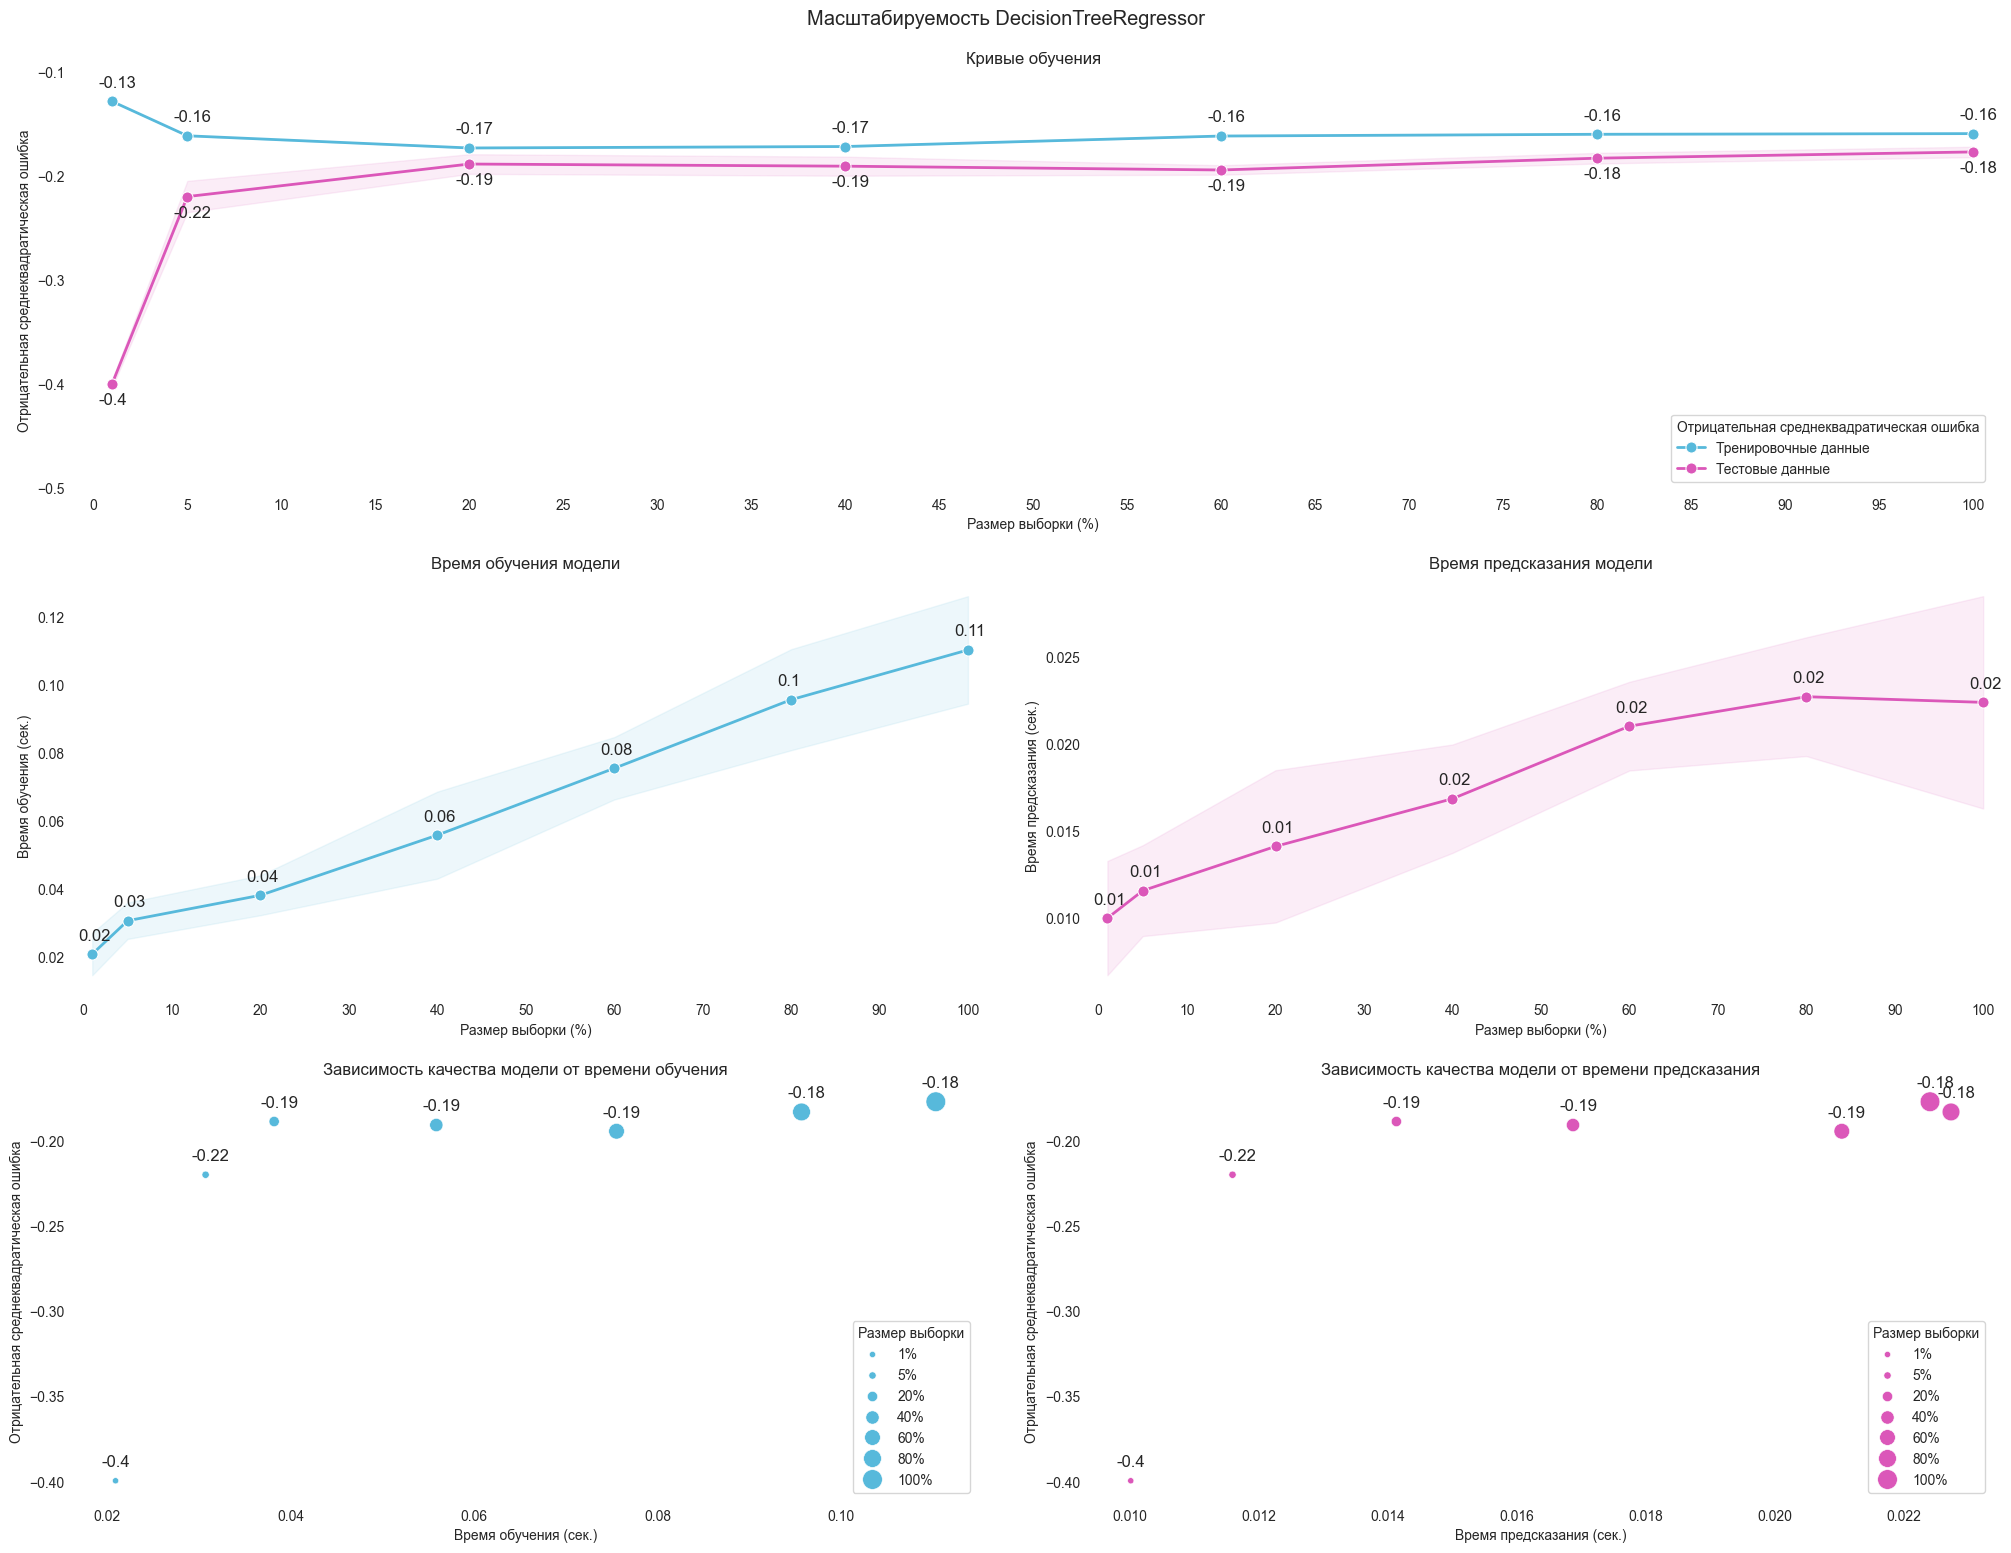

In [50]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость DecisionTreeRegressor'
)

In [51]:
predict = dt_rgs.predict(x_valid)

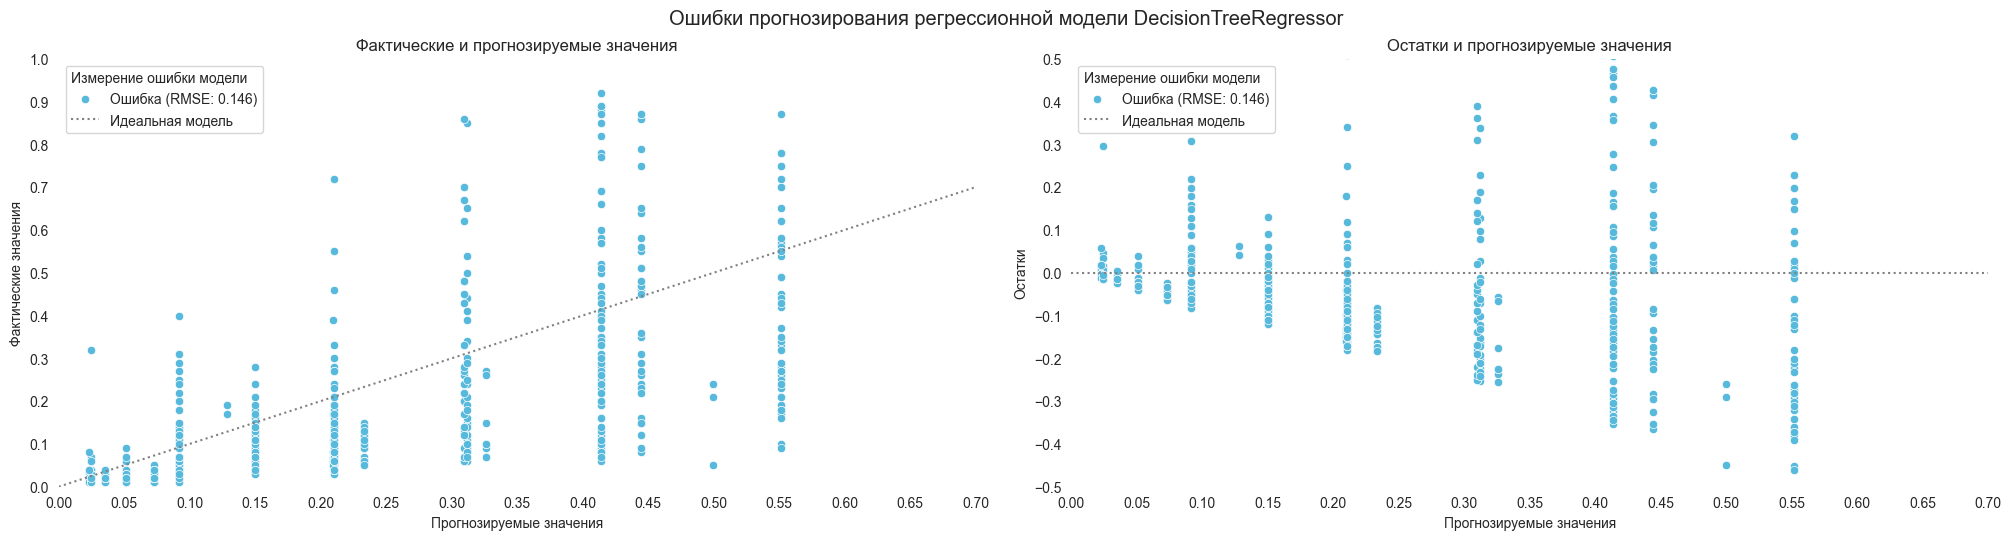

In [52]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели DecisionTreeRegressor'
)

### Тестирование RandomForestRegressor

In [53]:
category = [
    'platform', 
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [54]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', RandomForestRegressor(random_state=42))])

In [55]:
param_grid = {
    'estimator__max_depth': range(2, 21),
    'estimator__min_samples_split': range(2, 11, 2),
    'estimator__min_samples_leaf': range(1, 10, 2)
}

In [56]:
best_param = {
    'estimator__max_depth': [12],
    'estimator__min_samples_split': [10],
    'estimator__min_samples_leaf': [9]
}

In [57]:
rf_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

rf_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__max_depth=12, estimator__min_samples_leaf=9, estimator__min_samples_split=10;, score=-0.165 total time=   3.9s
[CV 2/3] END estimator__max_depth=12, estimator__min_samples_leaf=9, estimator__min_samples_split=10;, score=-0.160 total time=   4.4s
[CV 3/3] END estimator__max_depth=12, estimator__min_samples_leaf=9, estimator__min_samples_split=10;, score=-0.148 total time=   4.7s


In [58]:
cv_results = pd.DataFrame(
    data=rf_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        4.43947      0.322998         0.038644        0.011108   

  param_estimator__max_depth param_estimator__min_samples_leaf  \
0                         12                                 9   

  param_estimator__min_samples_split  \
0                                 10   

                                              params  split0_test_score  \
0  {'estimator__max_depth': 12, 'estimator__min_s...          -0.164889   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            -0.1604          -0.148097        -0.157795        0.007099   

   rank_test_score  
0                1

In [59]:
results.loc['RandomForestRegressor', ('Без сгенерированных признаков', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['RandomForestRegressor', ('Без сгенерированных признаков', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['RandomForestRegressor', ('Без сгенерированных признаков', 'RMSE')] = cv_results.iloc[0, -3]

In [60]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=rf_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    5.4s remaining:   10.5s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:   11.5s remaining:    5.2s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   21.5s finished


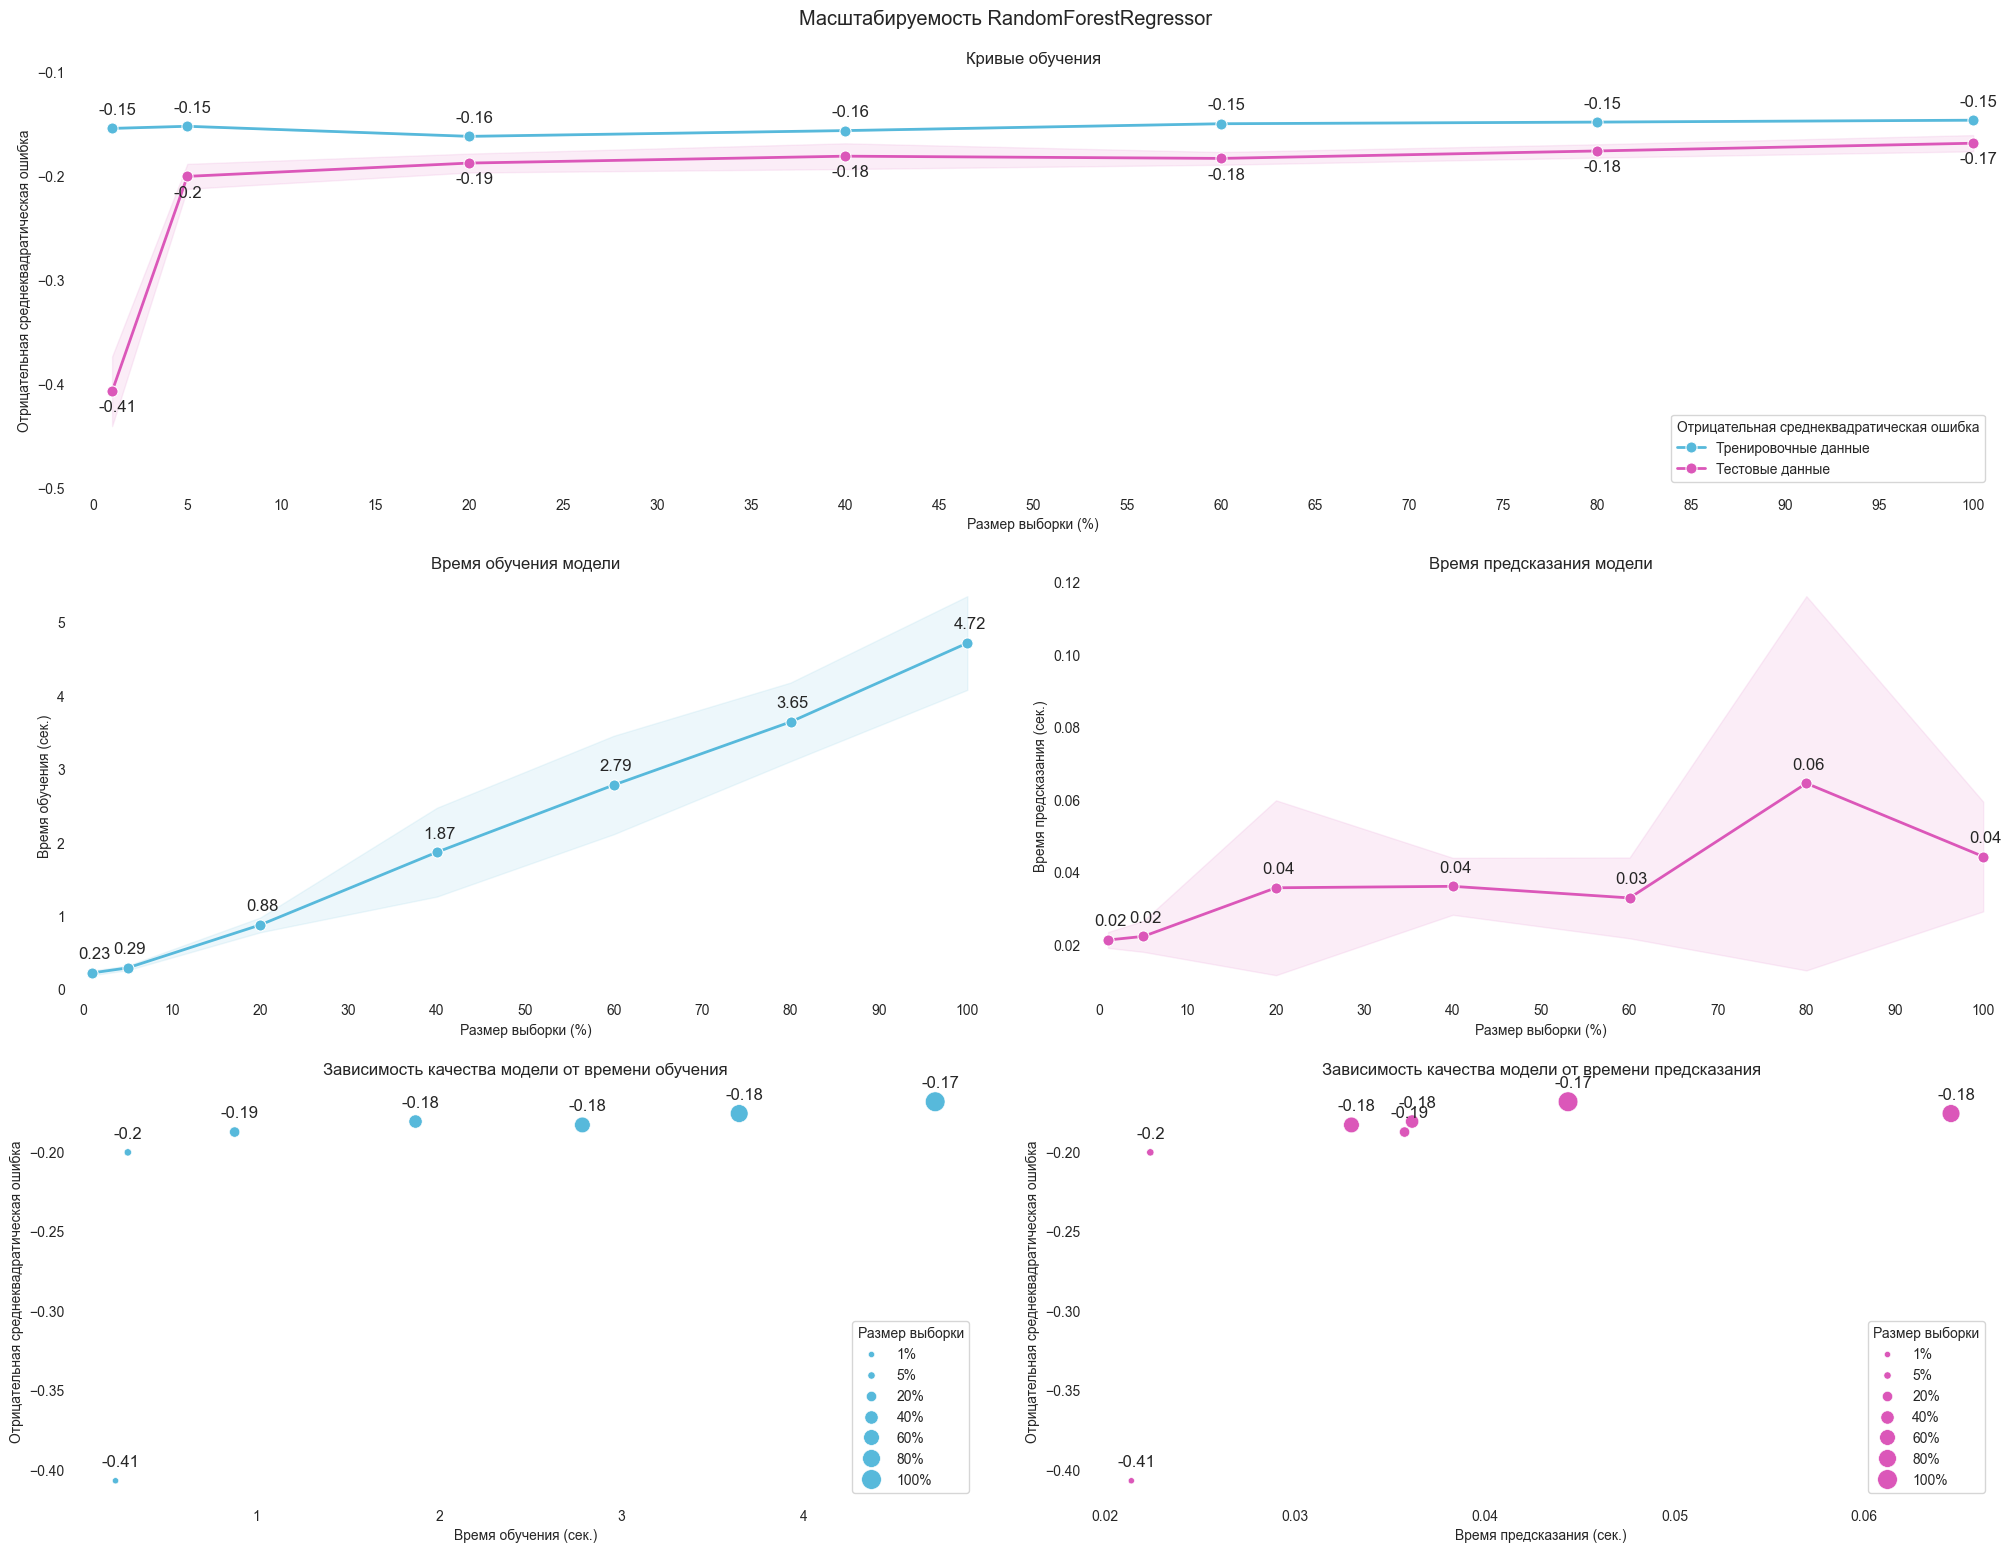

In [61]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость RandomForestRegressor'
)

In [62]:
predict = rf_rgs.predict(x_valid)

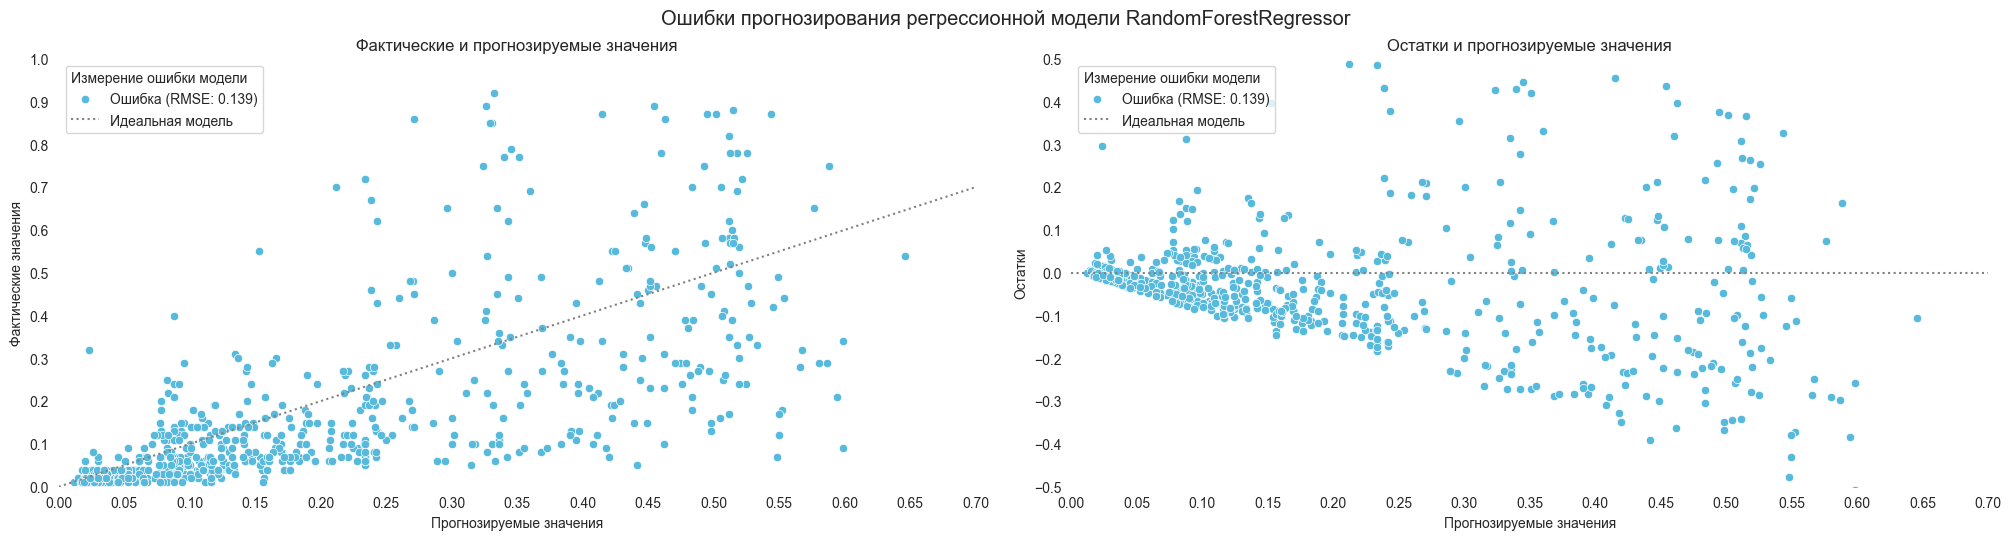

In [63]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели RandomForestRegressor'
)

### Тестирование HistGradientBoostingRegressor

In [64]:
category = [
    'platform', 
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [65]:
estimator = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', HistGradientBoostingRegressor(random_state=42))])

In [66]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [2, 4, 6, 8],
    'estimator__max_iter': [250, 500, 1000],
    'estimator__max_leaf_nodes': [20, 30, 40, 50],
    'estimator__min_samples_leaf': [20, 30, 40, 50],
    'estimator__l2_regularization': [0.0, 0.25, 0.5, 0.75],
}

In [67]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [6],
    'estimator__max_iter': [1000],
    'estimator__max_leaf_nodes': [20],
    'estimator__min_samples_leaf': [50],
    'estimator__l2_regularization': [0.0],
}

In [68]:
hgb_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

hgb_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__l2_regularization=0.0, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__max_iter=1000, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=50;, score=-0.169 total time=   0.9s
[CV 2/3] END estimator__l2_regularization=0.0, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__max_iter=1000, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=50;, score=-0.162 total time=   0.5s
[CV 3/3] END estimator__l2_regularization=0.0, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__max_iter=1000, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=50;, score=-0.141 total time=   0.5s


In [69]:
cv_results = pd.DataFrame(
    data=hgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.684776      0.177611         0.042641        0.009098   

  param_estimator__l2_regularization param_estimator__learning_rate  \
0                                0.0                            0.1   

  param_estimator__max_depth param_estimator__max_iter  \
0                          6                      1000   

  param_estimator__max_leaf_nodes param_estimator__min_samples_leaf  \
0                              20                                50   

                                              params  split0_test_score  \
0  {'estimator__l2_regularization': 0.0, 'estimat...          -0.168606   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.161969          -0.140696         -0.15709        0.011905   

   rank_test_score  
0                1

In [70]:
results.loc['HistGradientBoostingRegressor', ('Без сгенерированных признаков', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['HistGradientBoostingRegressor', ('Без сгенерированных признаков', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['HistGradientBoostingRegressor', ('Без сгенерированных признаков', 'RMSE')] = cv_results.iloc[0, -3]

In [71]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=hgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:   13.8s remaining:   26.6s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:   23.8s remaining:   10.9s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   36.1s finished


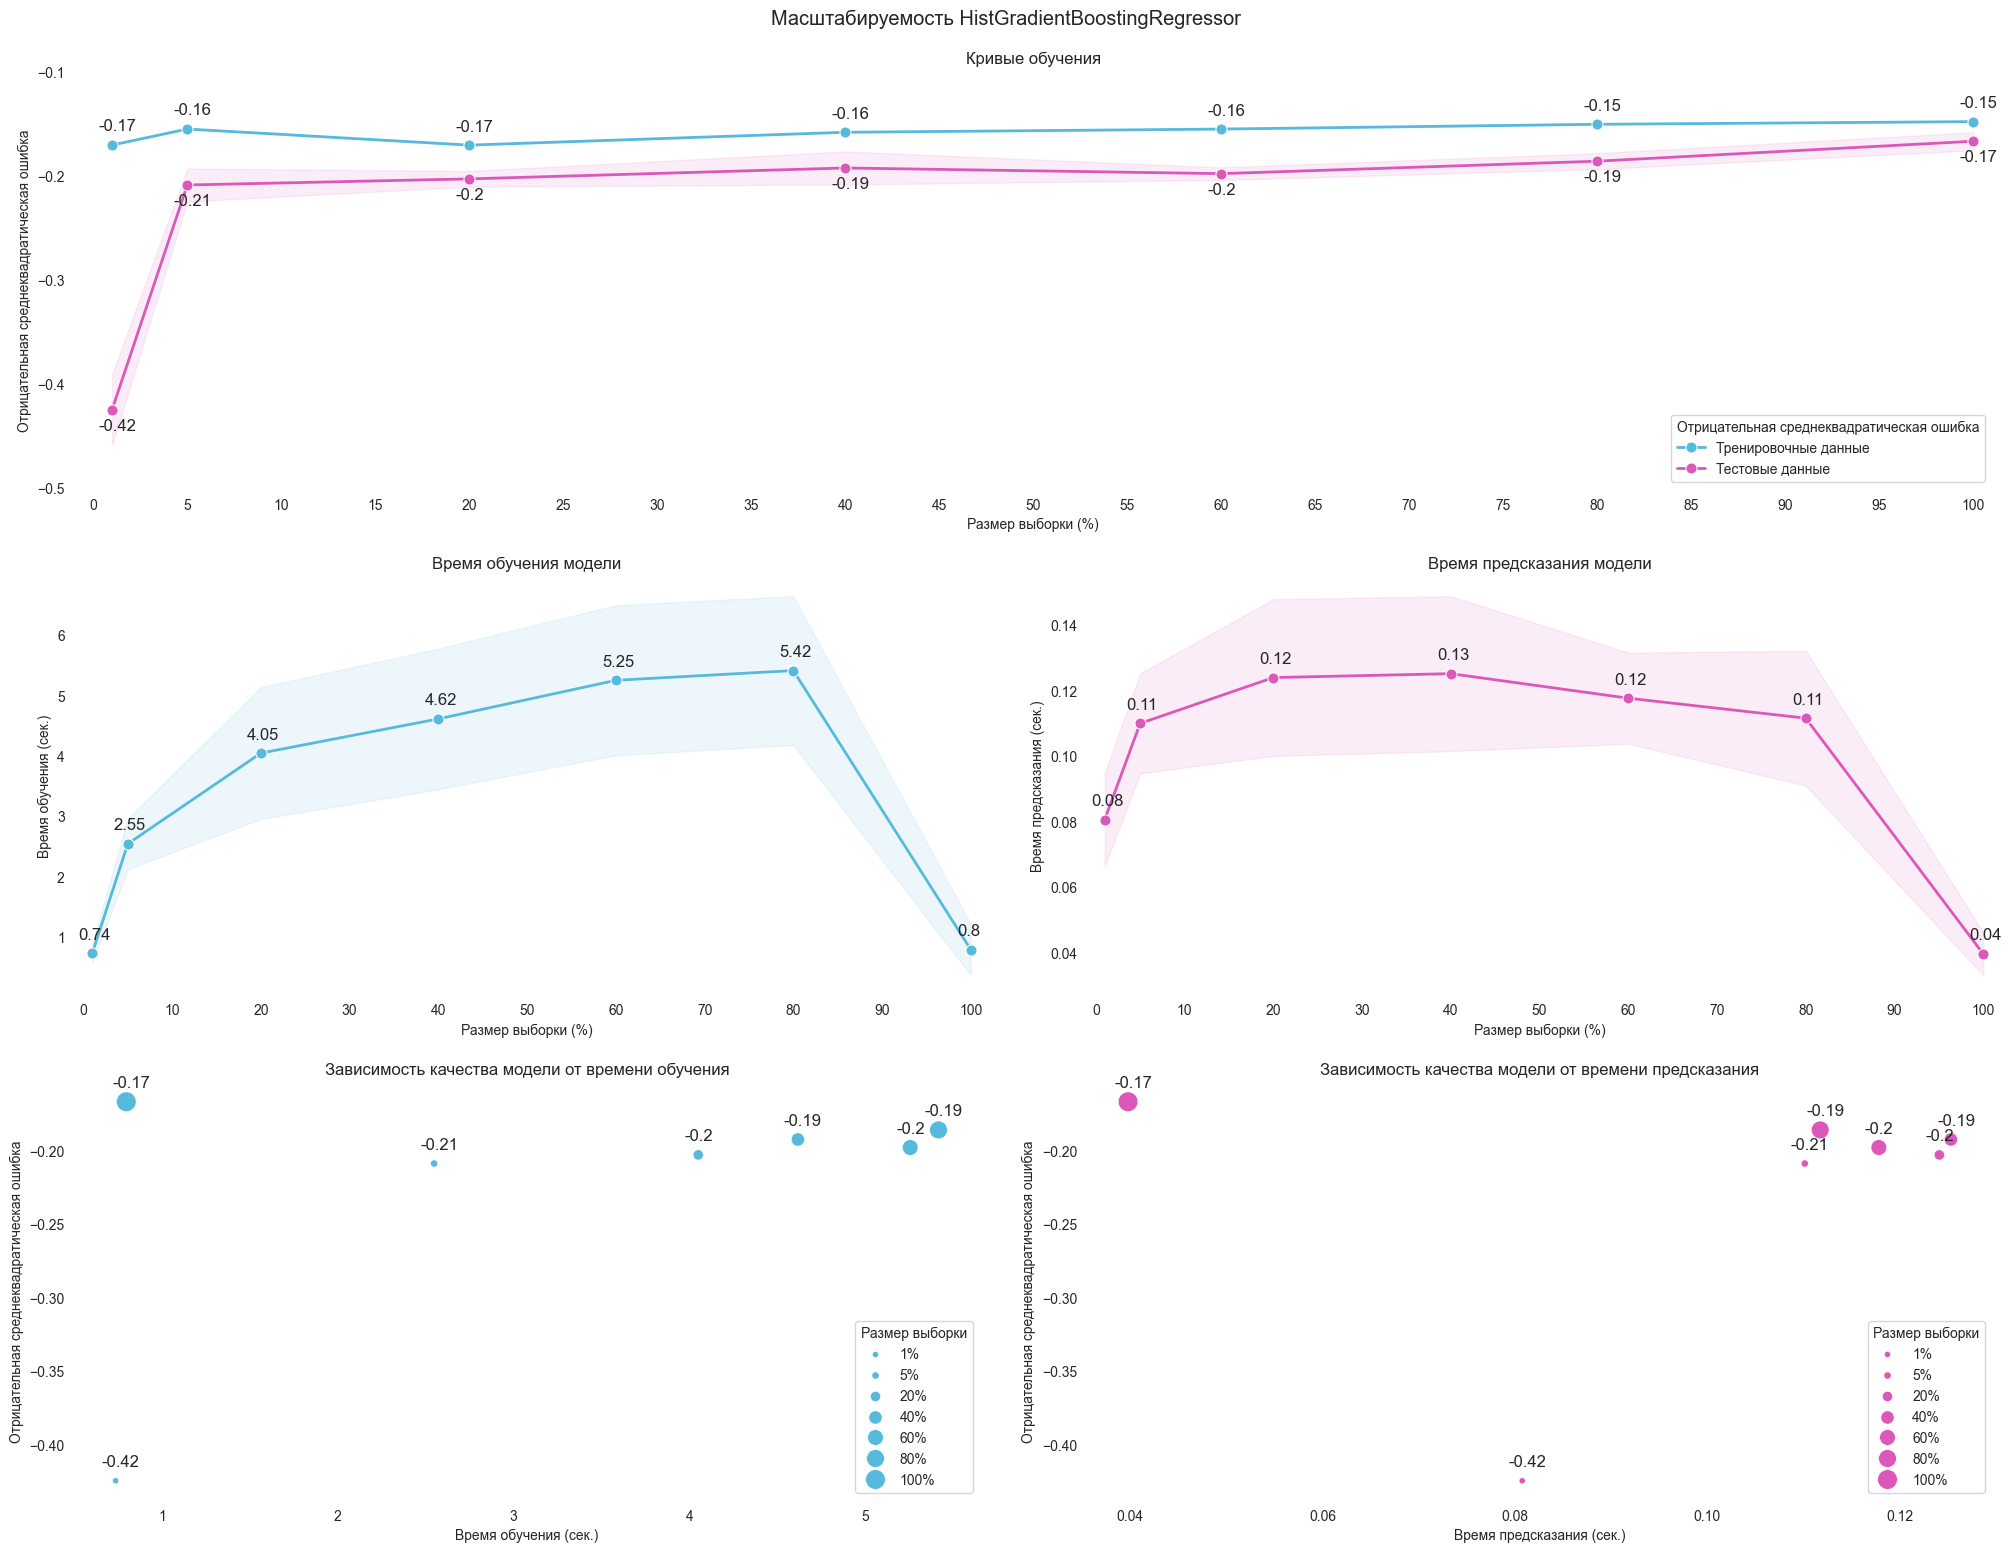

In [72]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость HistGradientBoostingRegressor'
)

In [73]:
predict = hgb_rgs.predict(x_valid)

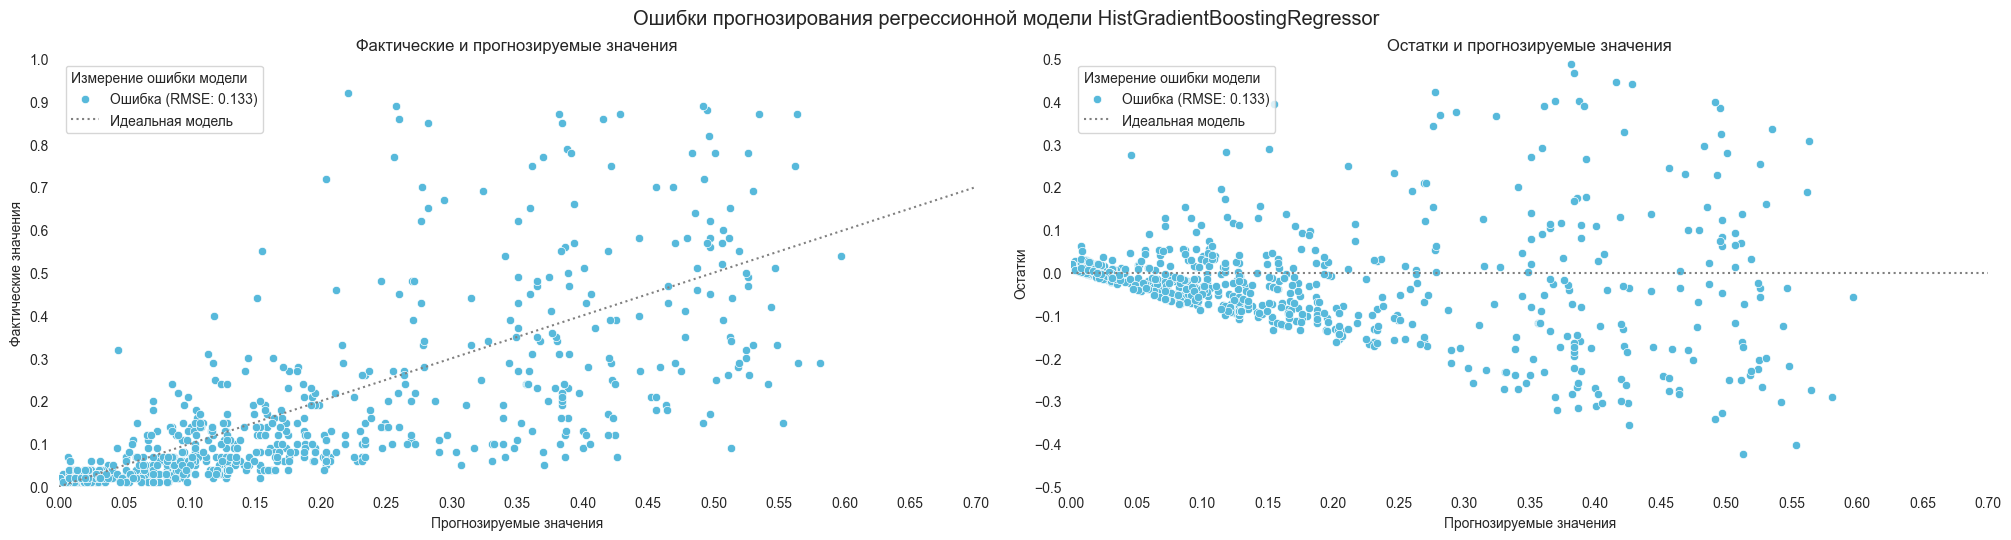

In [74]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели HistGradientBoostingRegressor'
)

### Тестирование LGBMRegressor

In [75]:
category = [
    'platform', 
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [76]:
estimator = LGBMRegressor(
    random_state=RANDOM_STATE,
    verbosity=-1
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', LGBMRegressor(random_state=42, verbosity=-1))])

In [77]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [2, 4, 6, 8],
    'estimator__n_estimators': [250, 500, 1000],
    'estimator__num_leaves': [20, 30, 40, 50],
    'estimator__reg_alpha': [0.0, 0.25, 0.5, 0.75],
    'estimator__reg_lambda': [0.0, 0.25, 0.5, 0.75],
}

In [78]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [4],
    'estimator__n_estimators': [250],
    'estimator__num_leaves': [40],
    'estimator__reg_alpha': [0.0],
    'estimator__reg_lambda': [0.25],
}

In [79]:
lgbm_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

lgbm_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__learning_rate=0.1, estimator__max_depth=4, estimator__n_estimators=250, estimator__num_leaves=40, estimator__reg_alpha=0.0, estimator__reg_lambda=0.25;, score=-0.172 total time=   0.5s
[CV 2/3] END estimator__learning_rate=0.1, estimator__max_depth=4, estimator__n_estimators=250, estimator__num_leaves=40, estimator__reg_alpha=0.0, estimator__reg_lambda=0.25;, score=-0.162 total time=   0.2s
[CV 3/3] END estimator__learning_rate=0.1, estimator__max_depth=4, estimator__n_estimators=250, estimator__num_leaves=40, estimator__reg_alpha=0.0, estimator__reg_lambda=0.25;, score=-0.141 total time=   0.2s


In [80]:
cv_results = pd.DataFrame(
    data=lgbm_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.350801      0.119443         0.035641        0.001692   

  param_estimator__learning_rate param_estimator__max_depth  \
0                            0.1                          4   

  param_estimator__n_estimators param_estimator__num_leaves  \
0                           250                          40   

  param_estimator__reg_alpha param_estimator__reg_lambda  \
0                        0.0                        0.25   

                                              params  split0_test_score  \
0  {'estimator__learning_rate': 0.1, 'estimator__...          -0.171781   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.162059          -0.140661        -0.158167        0.012999   

   rank_test_score  
0                1

In [81]:
results.loc['LGBMRegressor', ('Без сгенерированных признаков', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['LGBMRegressor', ('Без сгенерированных признаков', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['LGBMRegressor', ('Без сгенерированных признаков', 'RMSE')] = cv_results.iloc[0, -3]

In [82]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=lgbm_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    3.2s remaining:    6.3s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:    5.0s remaining:    2.2s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    6.9s finished


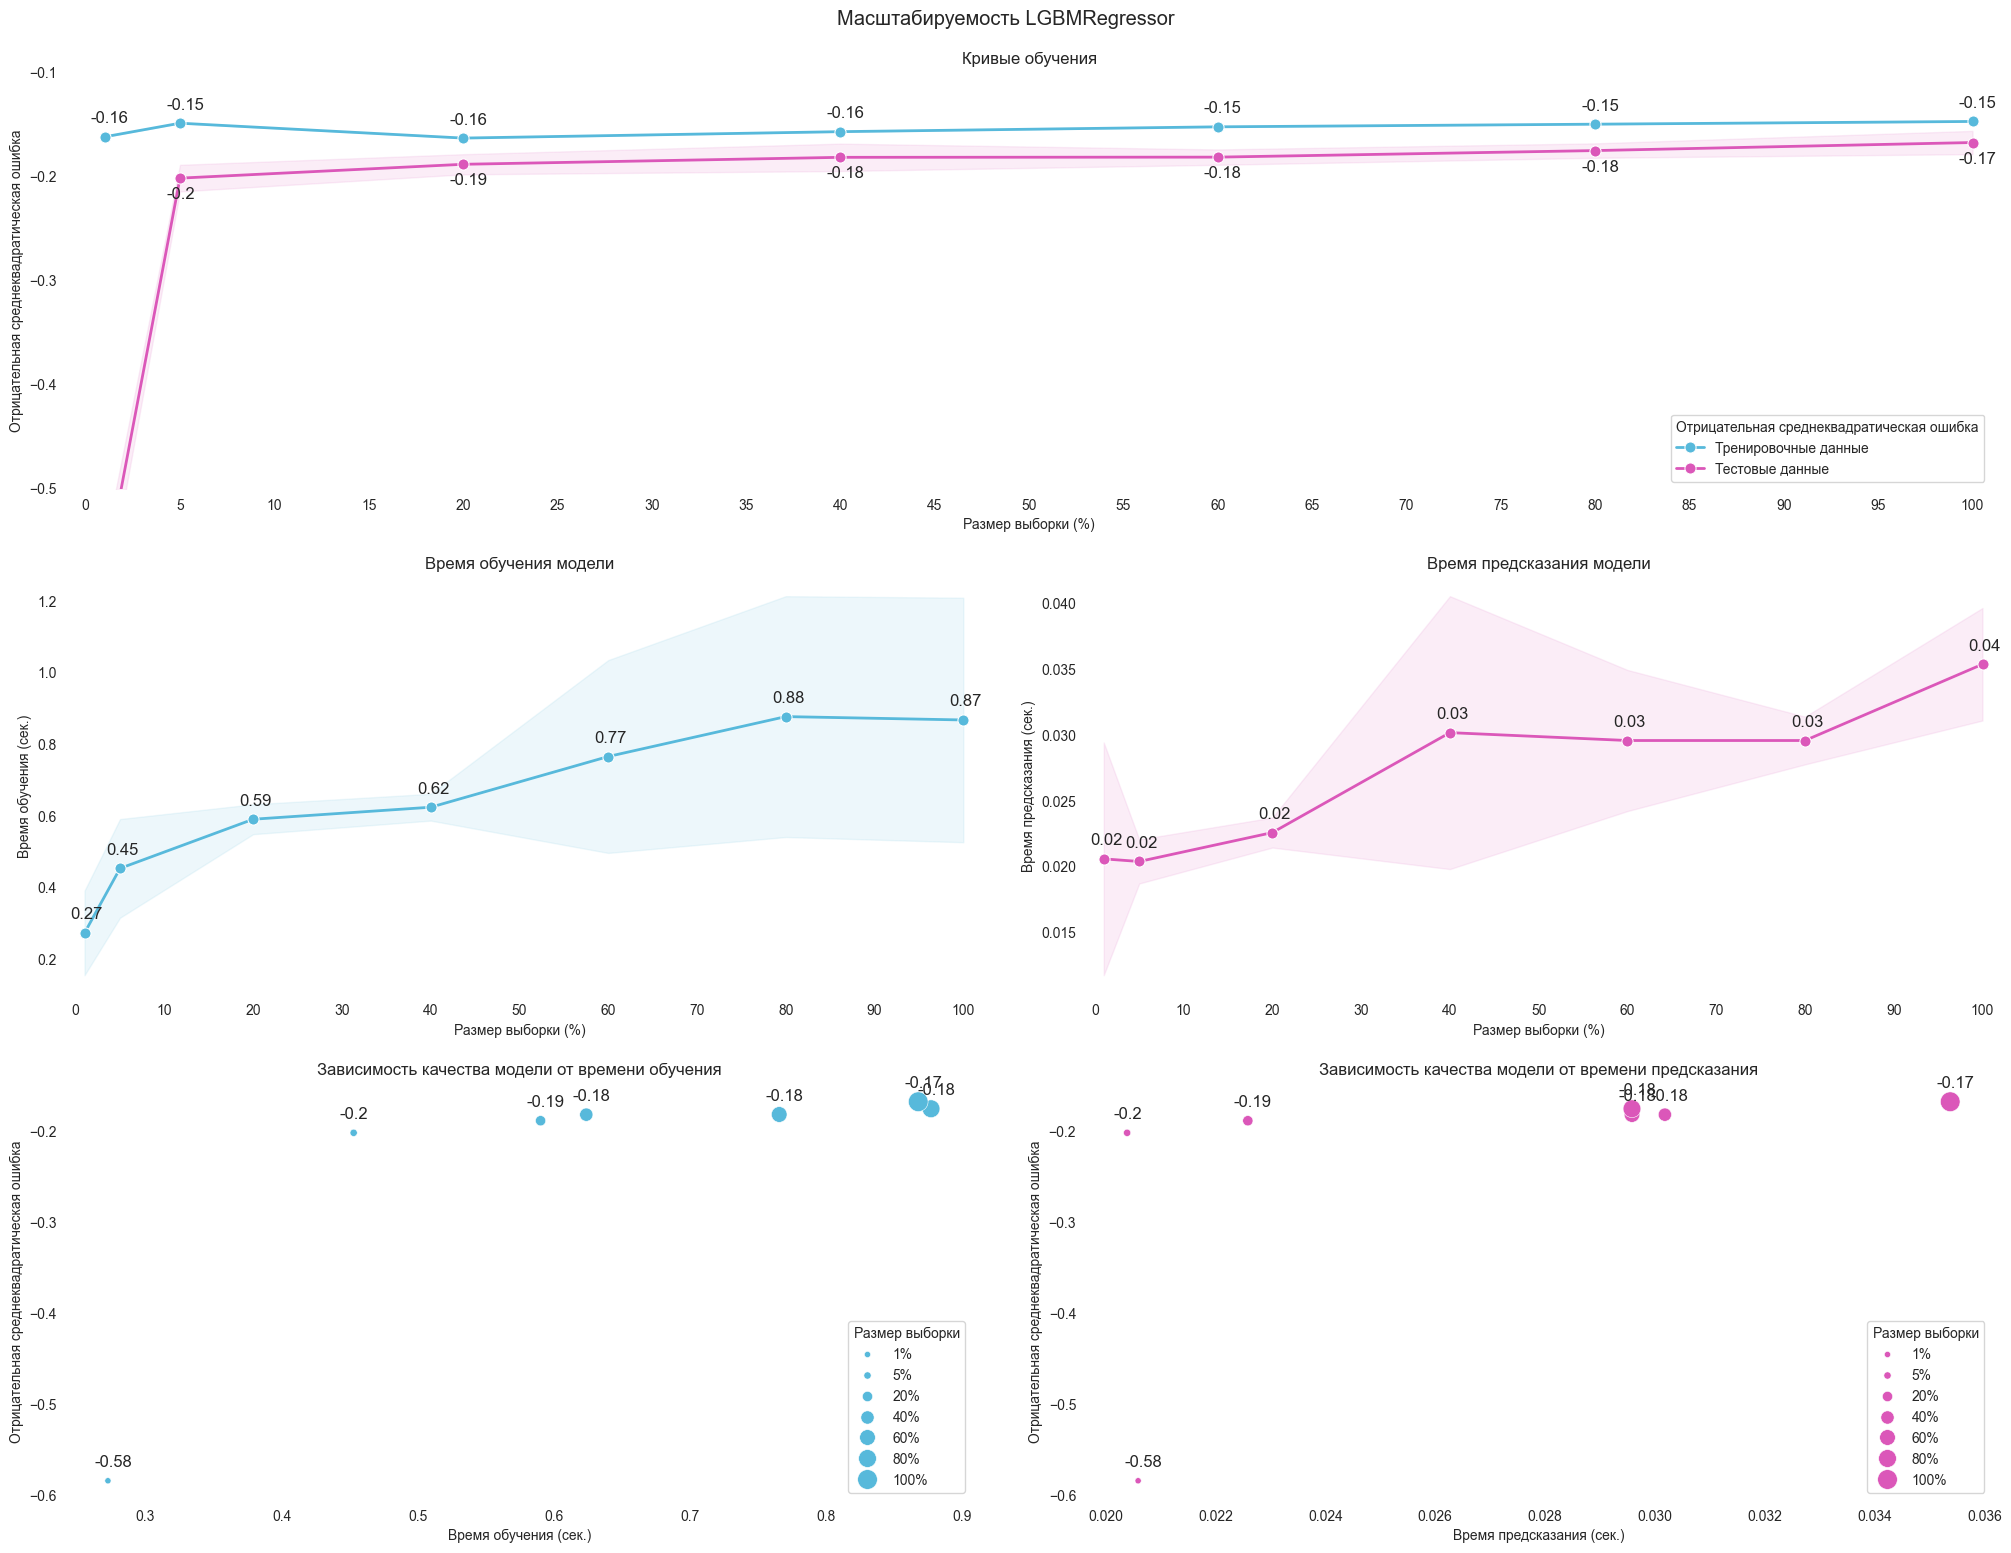

In [83]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость LGBMRegressor'
)

In [84]:
predict = lgbm_rgs.predict(x_valid)

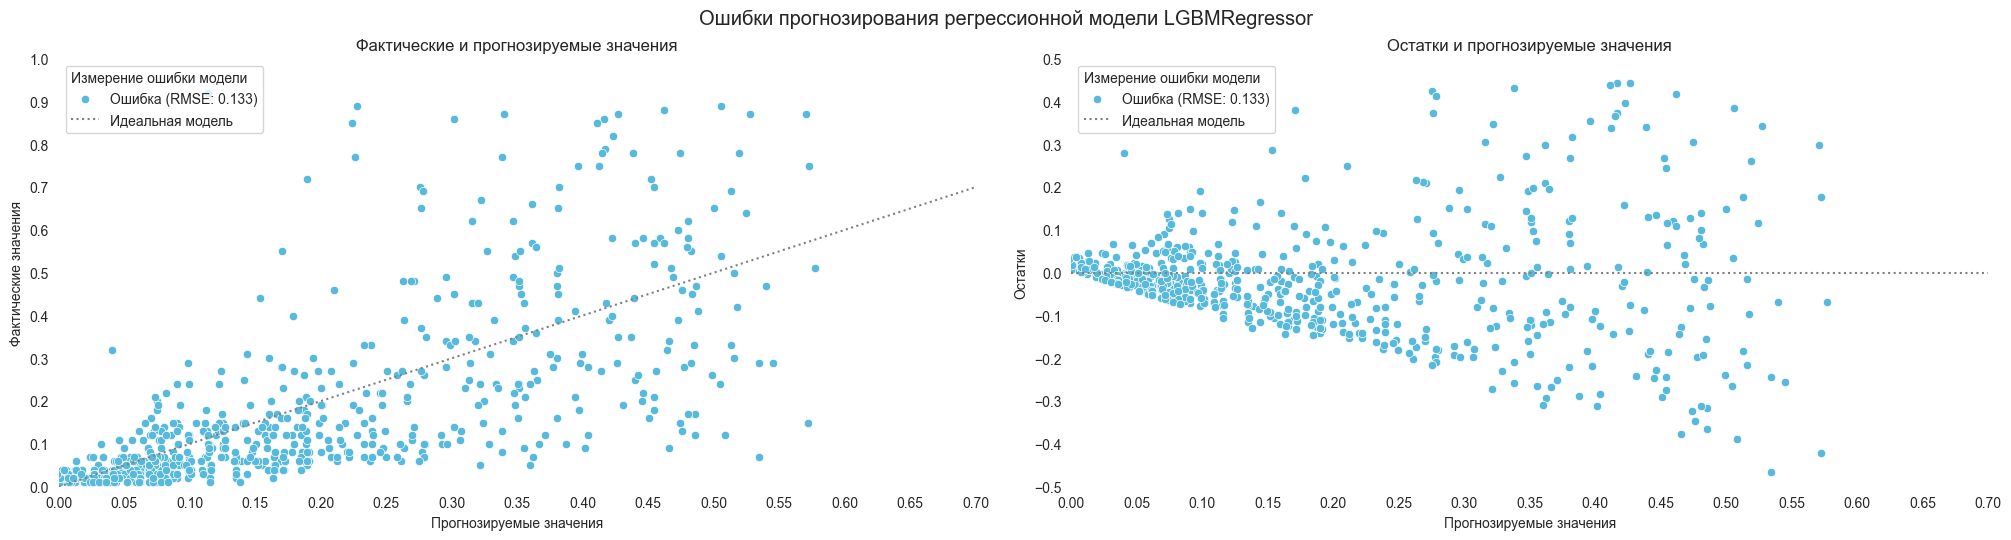

In [85]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели LGBMRegressor'
)

### Тестирование XGBRegressor

In [86]:
category = [
    'platform', 
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [87]:
estimator = XGBRegressor(
    random_state=RANDOM_STATE,
    verbosity=0
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [88]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [2, 4, 6, 8],
    'estimator__n_estimators': [250, 500, 1000],
    'estimator__max_leaves': [20, 30, 40, 50],
    'estimator__reg_alpha': [0.0, 0.25, 0.5, 0.75],
    'estimator__reg_lambda': [0.0, 0.25, 0.5, 0.75],
}

In [89]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [2],
    'estimator__n_estimators': [250],
    'estimator__max_leaves': [20],
    'estimator__reg_alpha': [0.0],
    'estimator__reg_lambda': [0.25],
}

In [90]:
xgb_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

xgb_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, estimator__n_estimators=250, estimator__reg_alpha=0.0, estimator__reg_lambda=0.25;, score=-0.168 total time=   0.7s
[CV 2/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, estimator__n_estimators=250, estimator__reg_alpha=0.0, estimator__reg_lambda=0.25;, score=-0.168 total time=   0.4s
[CV 3/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, estimator__n_estimators=250, estimator__reg_alpha=0.0, estimator__reg_lambda=0.25;, score=-0.144 total time=   0.2s


In [91]:
cv_results = pd.DataFrame(
    data=xgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.4983      0.172718         0.035646        0.006596   

  param_estimator__learning_rate param_estimator__max_depth  \
0                            0.1                          2   

  param_estimator__max_leaves param_estimator__n_estimators  \
0                          20                           250   

  param_estimator__reg_alpha param_estimator__reg_lambda  \
0                        0.0                        0.25   

                                              params  split0_test_score  \
0  {'estimator__learning_rate': 0.1, 'estimator__...          -0.167872   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.168112          -0.143537        -0.159841        0.011529   

   rank_test_score  
0                1

In [92]:
results.loc['XGBRegressor', ('Без сгенерированных признаков', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['XGBRegressor', ('Без сгенерированных признаков', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['XGBRegressor', ('Без сгенерированных признаков', 'RMSE')] = cv_results.iloc[0, -3]

In [93]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=xgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    1.2s remaining:    2.3s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:    2.1s remaining:    0.9s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    3.1s finished


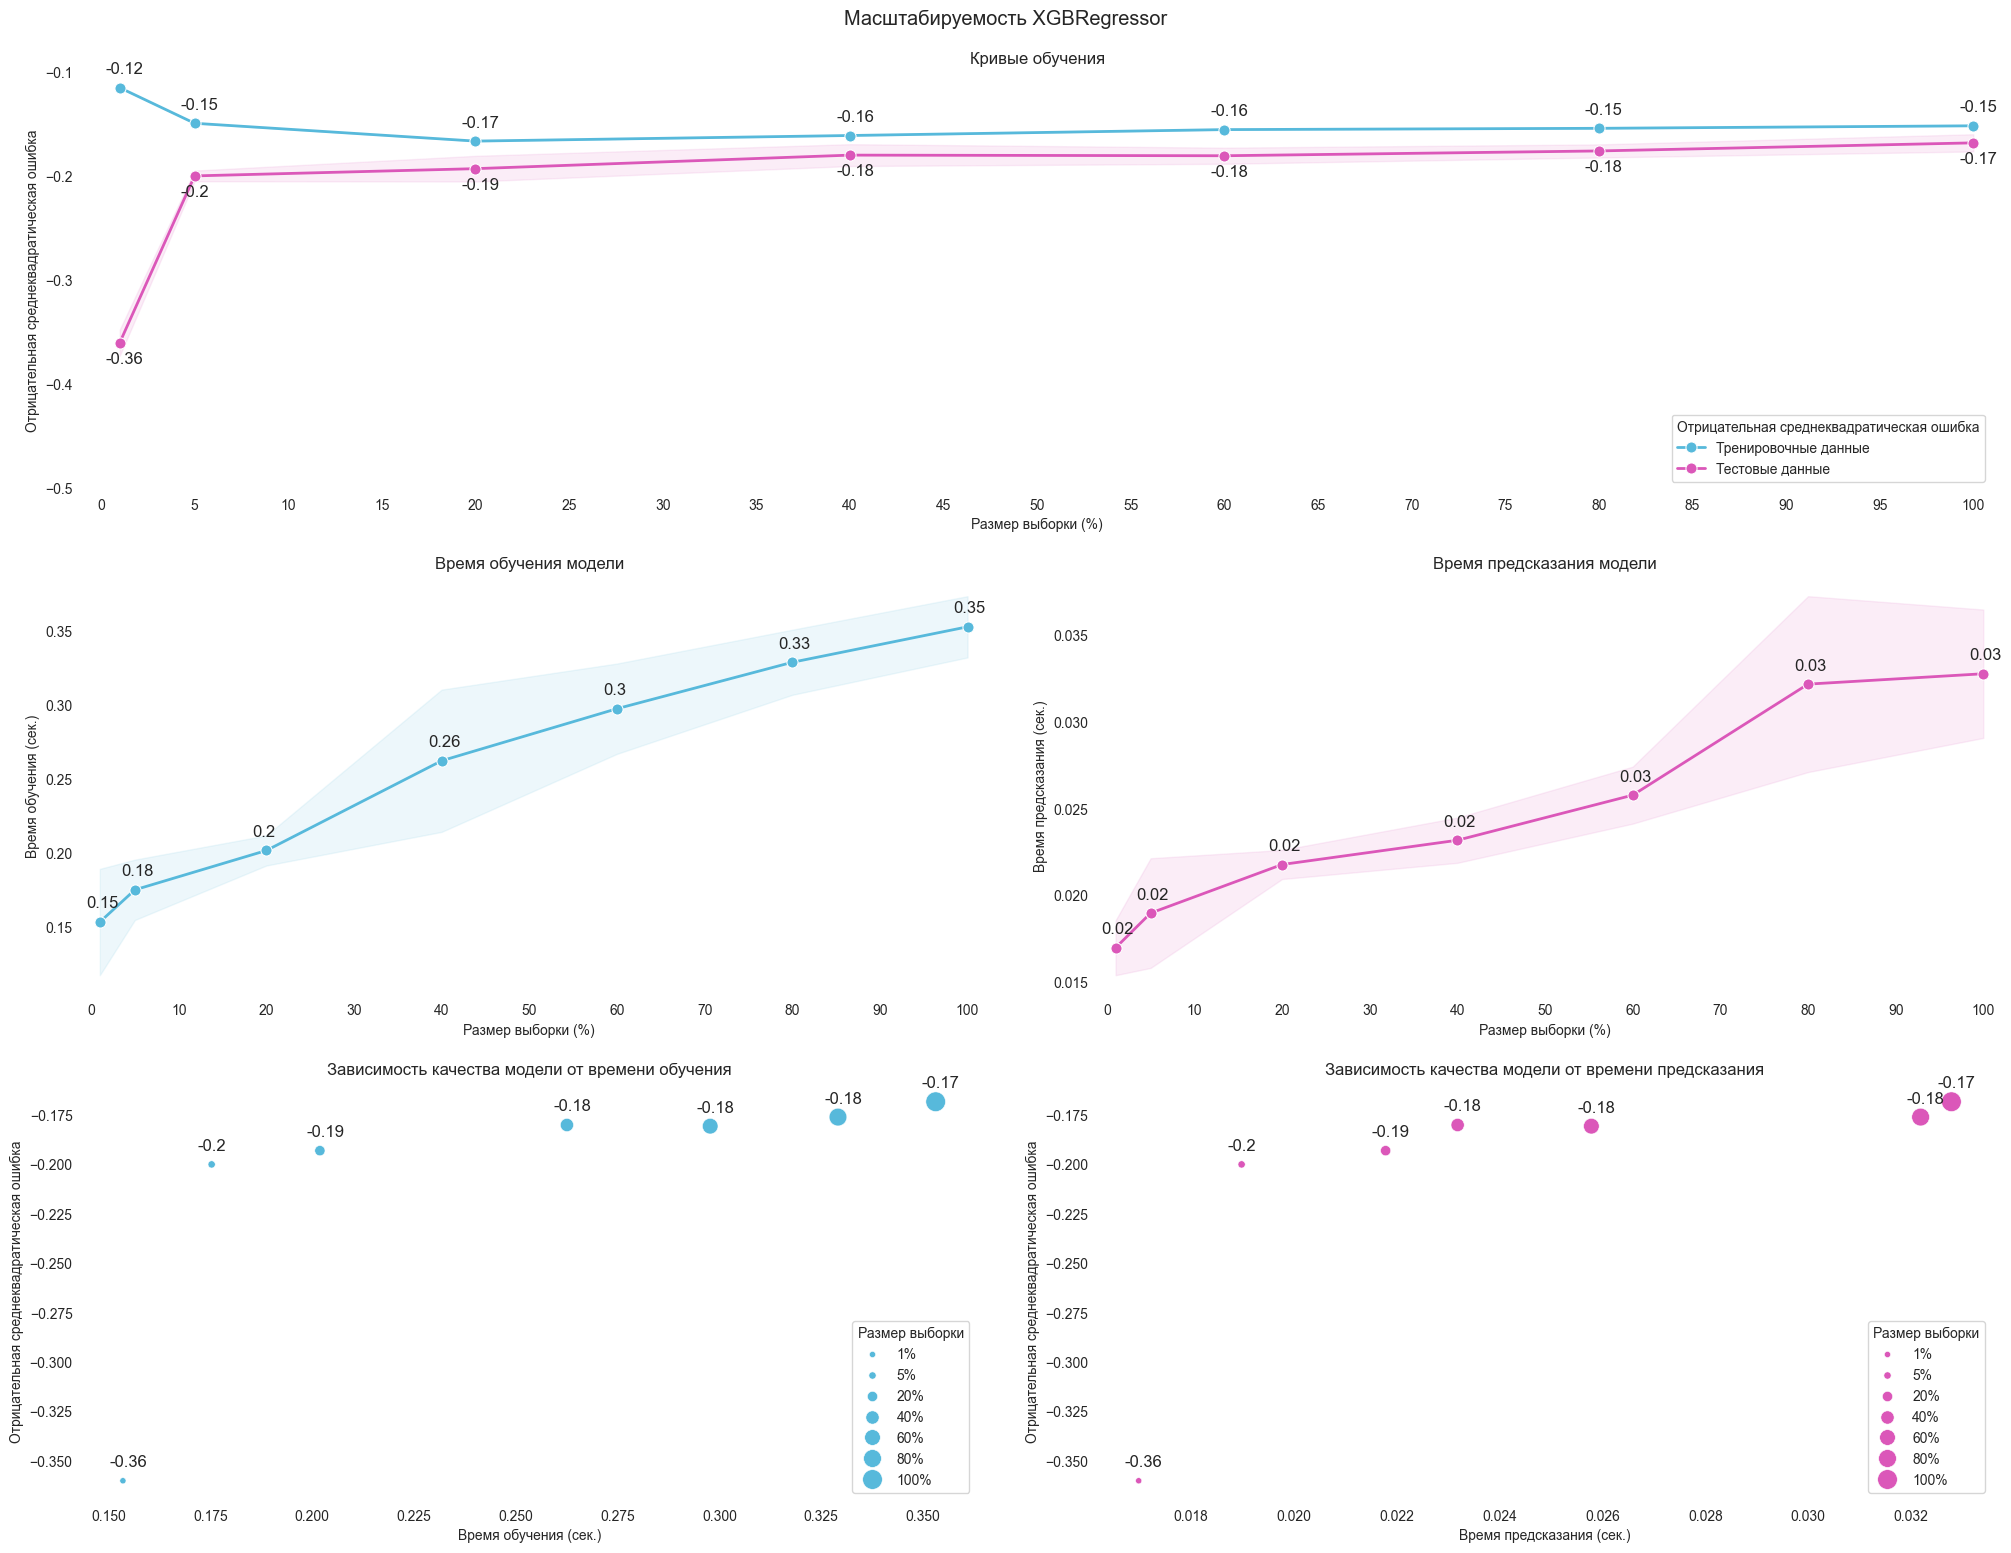

In [94]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость XGBRegressor'
)

In [95]:
predict = xgb_rgs.predict(x_valid)

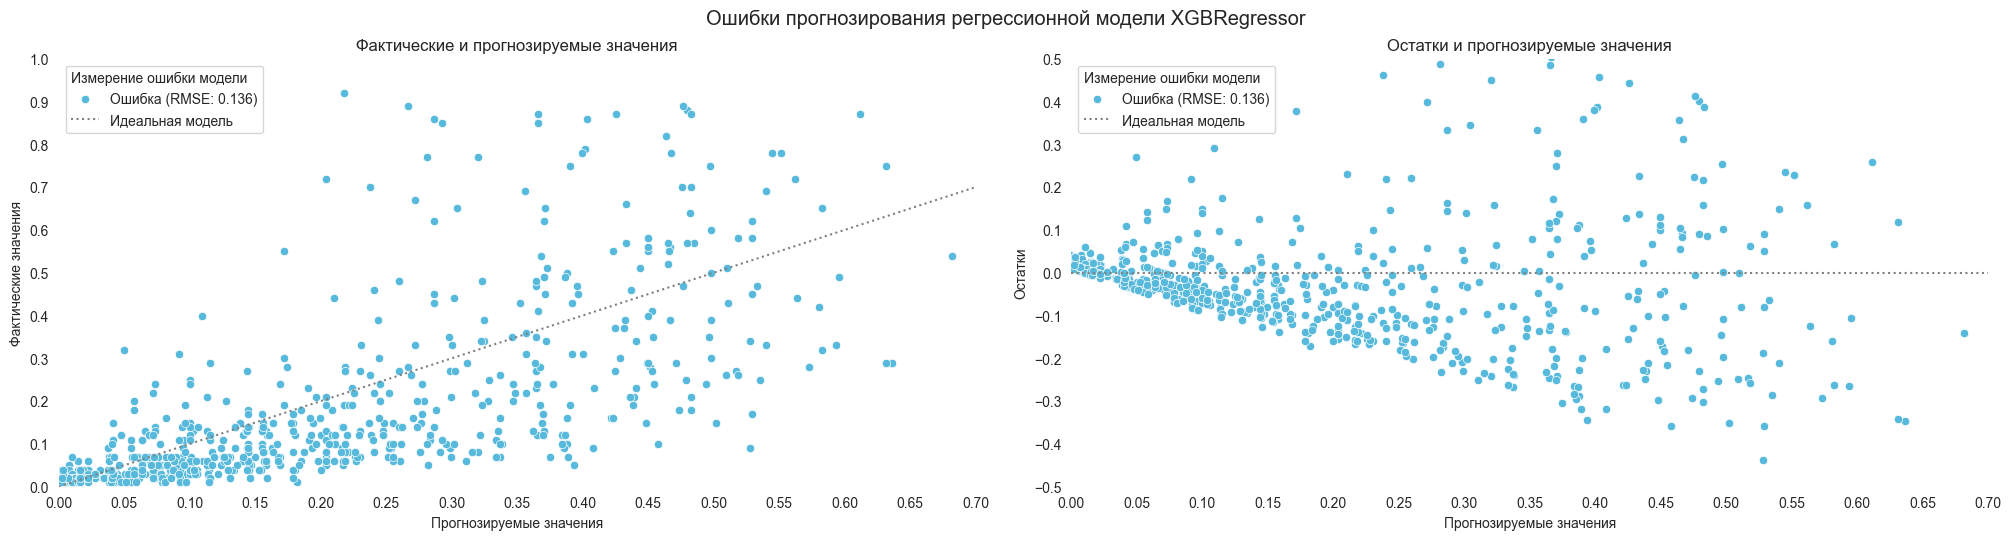

In [96]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели XGBRegressor'
)

### Выводы по тестированию моделей
***

In [97]:
results.style.format(na_rep='-')

1. Для кодирования признаков использован **TargetEncoder**.
2. Дляля оценки эффективности **предсказательной способности** модели использована метрика **RMSE**.
3. Для **оценки эффективности** были выбраны следующие показатели:
    - время обучения;
    - время предсказания;
    - RMSE.
4. DecisionTreeRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.5** сек.;
        - среднее время предсказания: до **0.02** сек.;
        - среднее значение RMSE: **0.165**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.146**;
        - **присутствует гетероскедастичность** остатков.
5. RandomForestRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **4.0** сек.;
        - среднее время предсказания: до **0.035** сек.;
        - среднее значение RMSE: **0.158**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.139**;
        - **присутствует гетероскедастичность** остатков.
6. HistGradientBoostingRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.6** сек.;
        - среднее время предсказания: до **0.03** сек.;
        - среднее значение RMSE: **0.133**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.157**;
        - **присутствует гетероскедастичность** остатков.
6. LGBMRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.35** сек.;
        - среднее время предсказания: до **0.035** сек.;
        - среднее значение RMSE: **0.158**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.133**;
        - **присутствует гетероскедастичность** остатков.
7. XGBRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.35** сек.;
        - среднее время предсказания: до **0.035** сек.;
        - среднее значение RMSE: **0.160**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.136**;
        - **присутствует гетероскедастичность** остатков.

## Генерация признаков
***

In [98]:
generate(x_train)

date platform            publisher                  developer  america  \
0      1970       PC            505 Games              BiArt Studios    False   
1      1970       PC  Paradox Interactive  Most Wanted Entertainment    False   
2      1977     2600                Atari                      Atari     True   
3      1977     2600                Atari                      Atari     True   
4      1978     2600                Atari                      Atari     True   
...     ...      ...                  ...                        ...      ...   
13969  2016      PS3           Activision              Infinity Ward     True   
13970  2016      PSV       Spike Chunsoft          RED Entertainment    False   
13971  2016      3DS   Namco Bandai Games         Bandai Namco Games    False   
13972  2016       PC                  GSP                        GSP    False   
13973  2016       PC                  GSP             Big Fish Games    False   

       europe  japan  other  countries   same  
0       False  False  False          0  False  
1        True  False  False          1  False  
2        True  False   True          3   True  
3        True  False  False          2   True  
4        True  False  False          2   True  
...       ...    ...    ...        ...    ...  
13969    True  False   True          3  False  
13970   False   True  False          1  False  
13971   False   True  False          1  False  
13972    True  False  False          1   True  
13973    True  False  False          1  False  

[13974 rows x 10 columns]

In [99]:
x_train = generate(x_train)

In [100]:
x_train

date platform            publisher                  developer  america  \
0      1970       PC            505 Games              BiArt Studios    False   
1      1970       PC  Paradox Interactive  Most Wanted Entertainment    False   
2      1977     2600                Atari                      Atari     True   
3      1977     2600                Atari                      Atari     True   
4      1978     2600                Atari                      Atari     True   
...     ...      ...                  ...                        ...      ...   
13969  2016      PS3           Activision              Infinity Ward     True   
13970  2016      PSV       Spike Chunsoft          RED Entertainment    False   
13971  2016      3DS   Namco Bandai Games         Bandai Namco Games    False   
13972  2016       PC                  GSP                        GSP    False   
13973  2016       PC                  GSP             Big Fish Games    False   

       europe  japan  other  countries   same  
0       False  False  False          0  False  
1        True  False  False          1  False  
2        True  False   True          3   True  
3        True  False  False          2   True  
4        True  False  False          2   True  
...       ...    ...    ...        ...    ...  
13969    True  False   True          3  False  
13970   False   True  False          1  False  
13971   False   True  False          1  False  
13972    True  False  False          1   True  
13973    True  False  False          1  False  

[13974 rows x 10 columns]

In [101]:
x_valid = generate(x_valid)

In [102]:
x_valid

date platform               publisher               developer  america  \
13974  2016       PC  Blizzard Entertainment  Blizzard Entertainment     True   
13975  2016      PS3              Activision           PlatinumGames     True   
13976  2016     X360              Activision           PlatinumGames     True   
13977  2016      PS4              Activision           PlatinumGames     True   
13978  2016     XOne           Kalypso Media         Haemimont Games     True   
...     ...      ...                     ...                     ...      ...   
14745  2017      3DS                Nintendo             Omega Force     True   
14746  2017       NS                Nintendo             Omega Force     True   
14747  2017       NS                Microids                Microids    False   
14748  2017       PC              Activision                  Bungie     True   
14749  2017     XOne           Kalypso Media           Studio Fizbin     True   

       europe  japan  other  countries   same  
13974    True  False   True          3   True  
13975    True  False   True          3  False  
13976    True  False   True          3  False  
13977    True  False   True          3  False  
13978   False  False  False          1  False  
...       ...    ...    ...        ...    ...  
14745    True   True   True          4  False  
14746    True   True   True          4  False  
14747    True  False  False          1   True  
14748    True  False   True          3  False  
14749   False  False  False          1  False  

[776 rows x 10 columns]

### DecisionTreeRegressor

In [103]:
category = [
    'platform',
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other', 
    'countries', 
    'same'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other',
                                  'countries', 'same'])])

In [104]:
estimator = DecisionTreeRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan', 'other',
                                                   'countries', 'same'])])),
                ('estimator', DecisionTreeRegressor(random_state=42))])

In [105]:
param_grid = {
    'estimator__max_depth': range(2, 21),
    'estimator__min_samples_split': range(2, 21, 2)
}

In [106]:
best_param = {
    'estimator__max_depth': [6],
    'estimator__min_samples_split': [12]
}

In [107]:
dt_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

dt_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__max_depth=6, estimator__min_samples_split=12;, score=-0.172 total time=   0.0s
[CV 2/3] END estimator__max_depth=6, estimator__min_samples_split=12;, score=-0.163 total time=   0.1s
[CV 3/3] END estimator__max_depth=6, estimator__min_samples_split=12;, score=-0.148 total time=   0.0s


In [108]:
cv_results = pd.DataFrame(
    data=dt_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.124693      0.009696         0.017657        0.002053   

  param_estimator__max_depth param_estimator__min_samples_split  \
0                          6                                 12   

                                              params  split0_test_score  \
0  {'estimator__max_depth': 6, 'estimator__min_sa...          -0.172107   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.163483          -0.148238        -0.161276        0.009869   

   rank_test_score  
0                1

In [109]:
results.loc['DecisionTreeRegressor', ('Со сгенерированными признаками', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['DecisionTreeRegressor', ('Со сгенерированными признаками', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['DecisionTreeRegressor', ('Со сгенерированными признаками', 'RMSE')] = cv_results.iloc[0, -3]

In [110]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=dt_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    1.7s finished


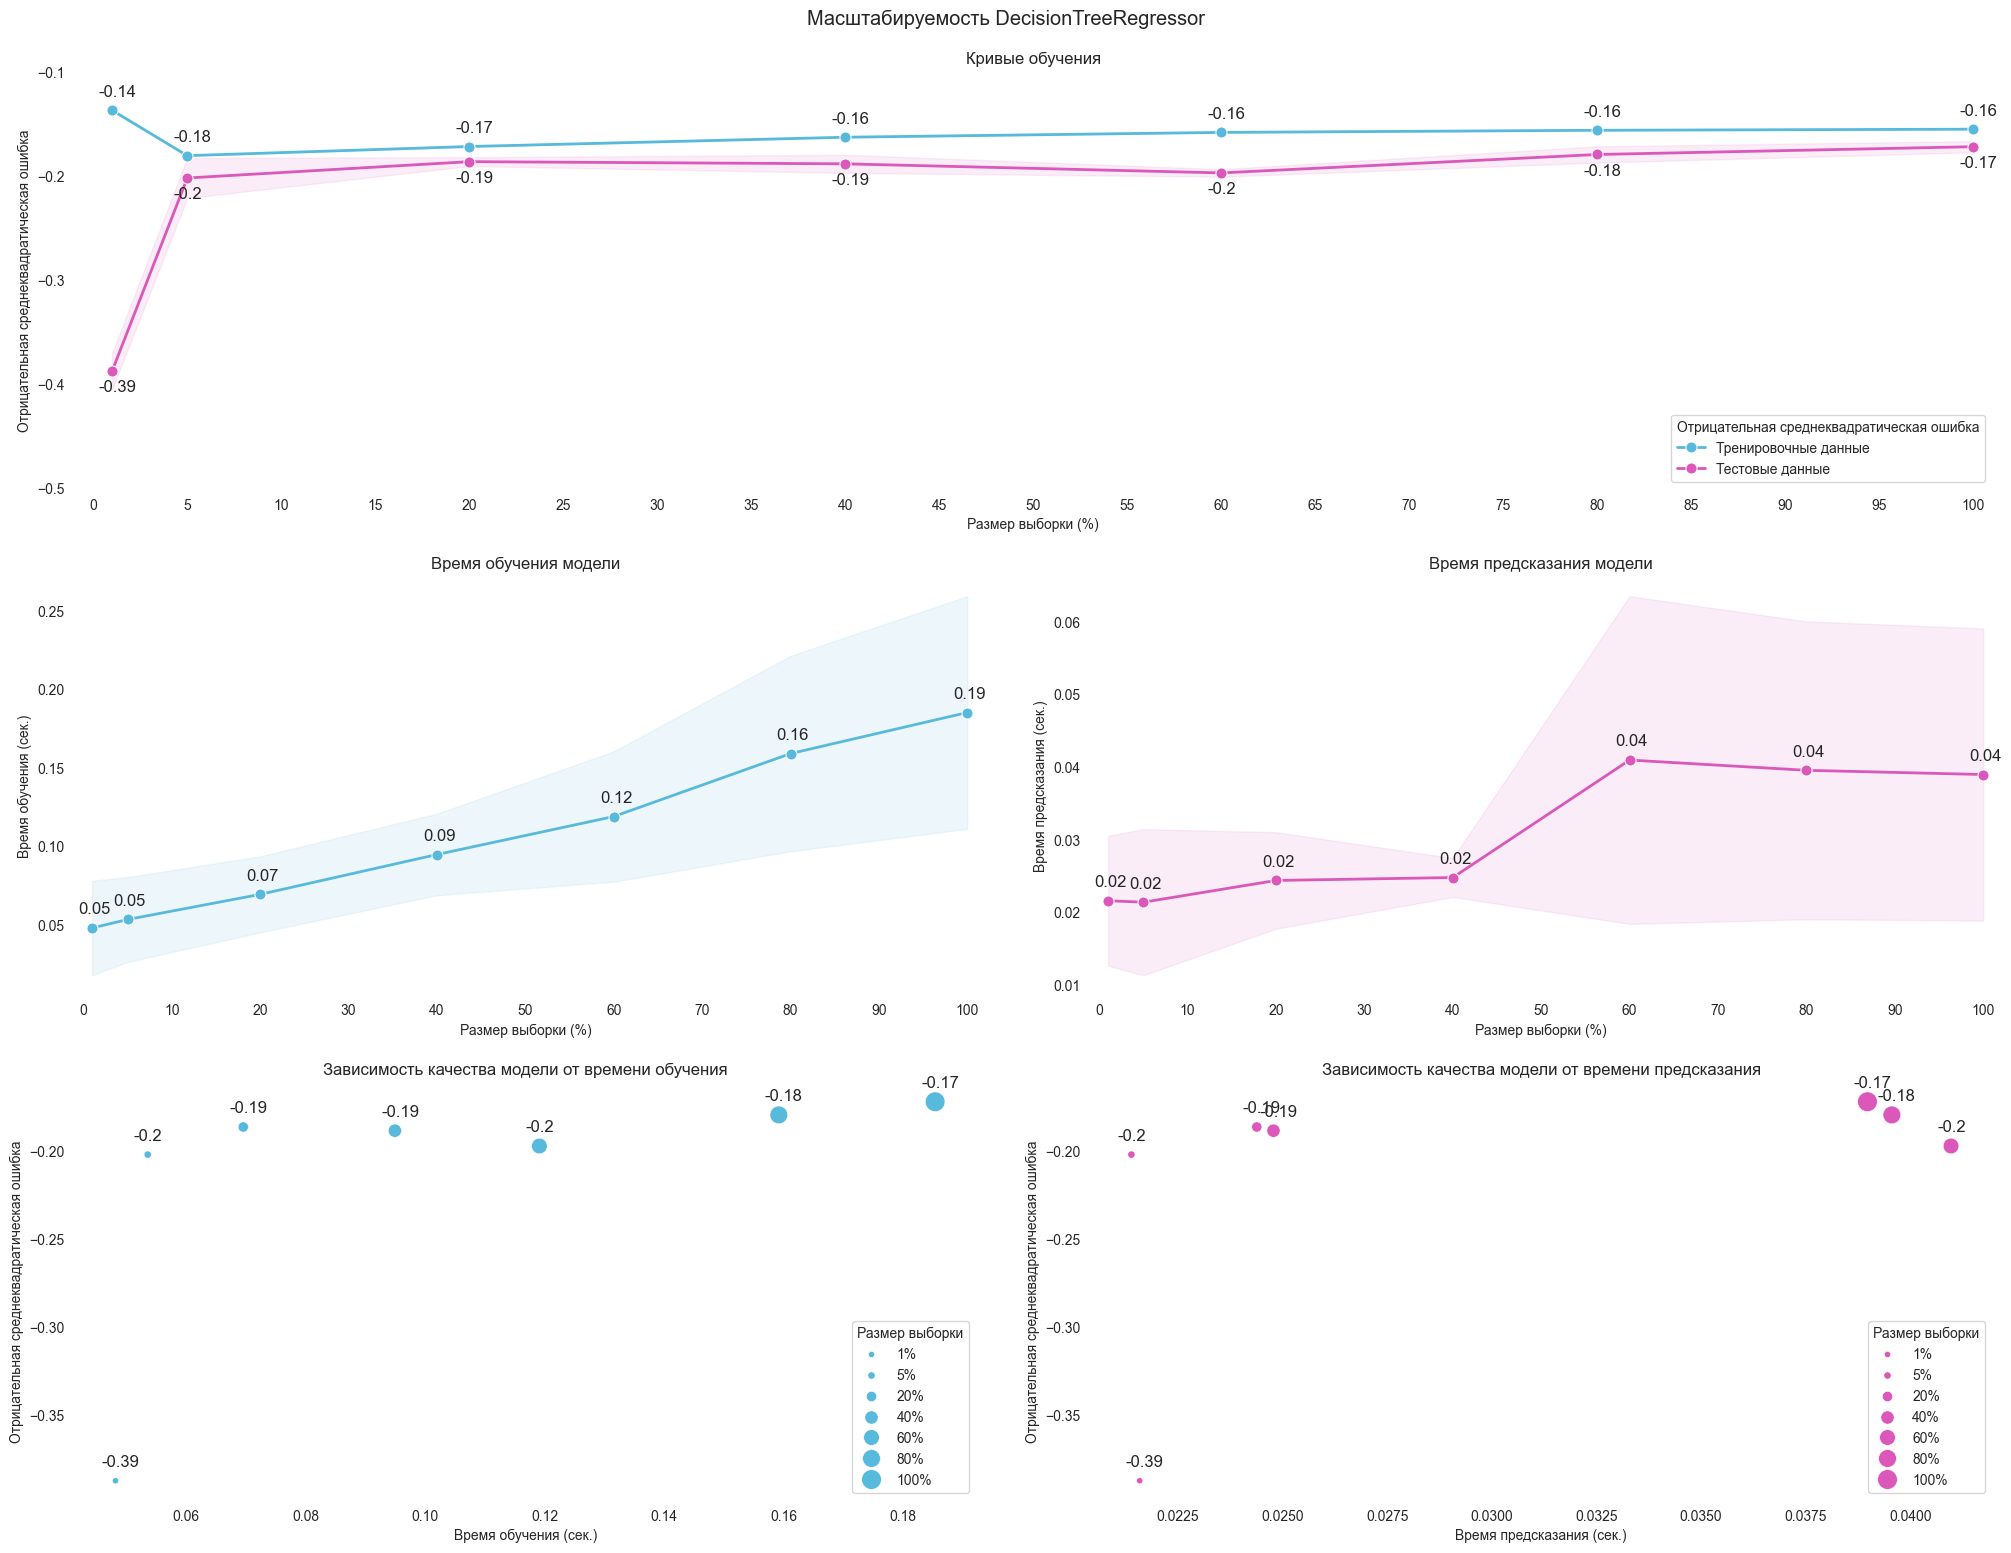

In [111]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость DecisionTreeRegressor'
)

In [112]:
predict = dt_rgs.predict(x_valid)

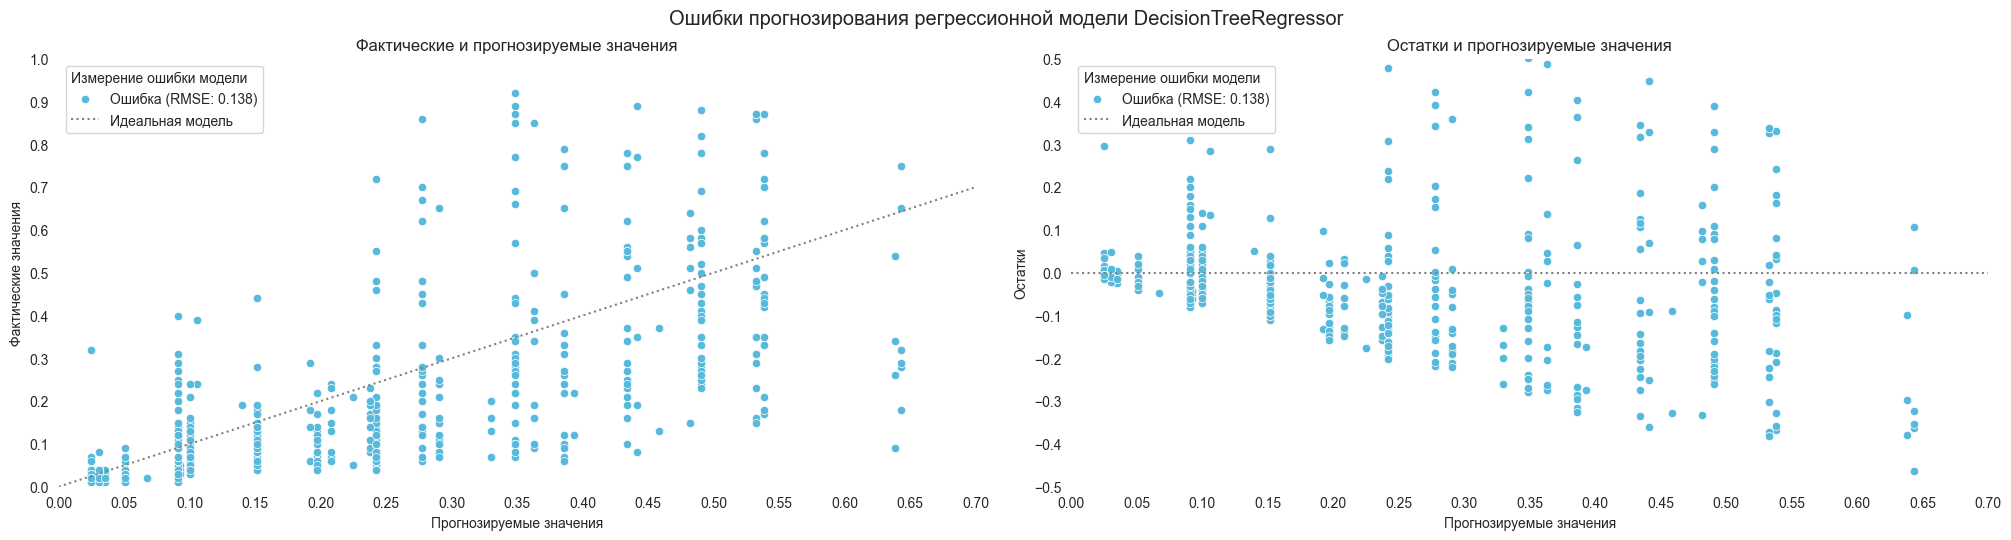

In [113]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели DecisionTreeRegressor'
)

### RandomForestRegressor

In [114]:
category = [
    'platform',
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other', 
    'countries', 
    'same'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other',
                                  'countries', 'same'])])

In [115]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan', 'other',
                                                   'countries', 'same'])])),
                ('estimator', RandomForestRegressor(random_state=42))])

In [116]:
param_grid = {
    'estimator__max_depth': range(2, 21),
    'estimator__min_samples_split': range(2, 11, 2),
    'estimator__min_samples_leaf': range(1, 10, 2)
}

In [117]:
best_param = {
    'estimator__max_depth': [11],
    'estimator__min_samples_split': [4],
    'estimator__min_samples_leaf': [7]
}

In [118]:
rf_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

rf_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__max_depth=11, estimator__min_samples_leaf=7, estimator__min_samples_split=4;, score=-0.165 total time=   4.6s
[CV 2/3] END estimator__max_depth=11, estimator__min_samples_leaf=7, estimator__min_samples_split=4;, score=-0.159 total time=   4.6s
[CV 3/3] END estimator__max_depth=11, estimator__min_samples_leaf=7, estimator__min_samples_split=4;, score=-0.147 total time=   4.7s


In [119]:
cv_results = pd.DataFrame(
    data=rf_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.631714      0.027561         0.062311        0.017618   

  param_estimator__max_depth param_estimator__min_samples_leaf  \
0                         11                                 7   

  param_estimator__min_samples_split  \
0                                  4   

                                              params  split0_test_score  \
0  {'estimator__max_depth': 11, 'estimator__min_s...          -0.165169   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.158876          -0.146949        -0.156998        0.007556   

   rank_test_score  
0                1

In [120]:
results.loc['RandomForestRegressor', ('Со сгенерированными признаками', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['RandomForestRegressor', ('Со сгенерированными признаками', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['RandomForestRegressor', ('Со сгенерированными признаками', 'RMSE')] = cv_results.iloc[0, -3]

In [121]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=rf_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    7.7s remaining:   14.9s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:   15.3s remaining:    7.0s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   24.7s finished


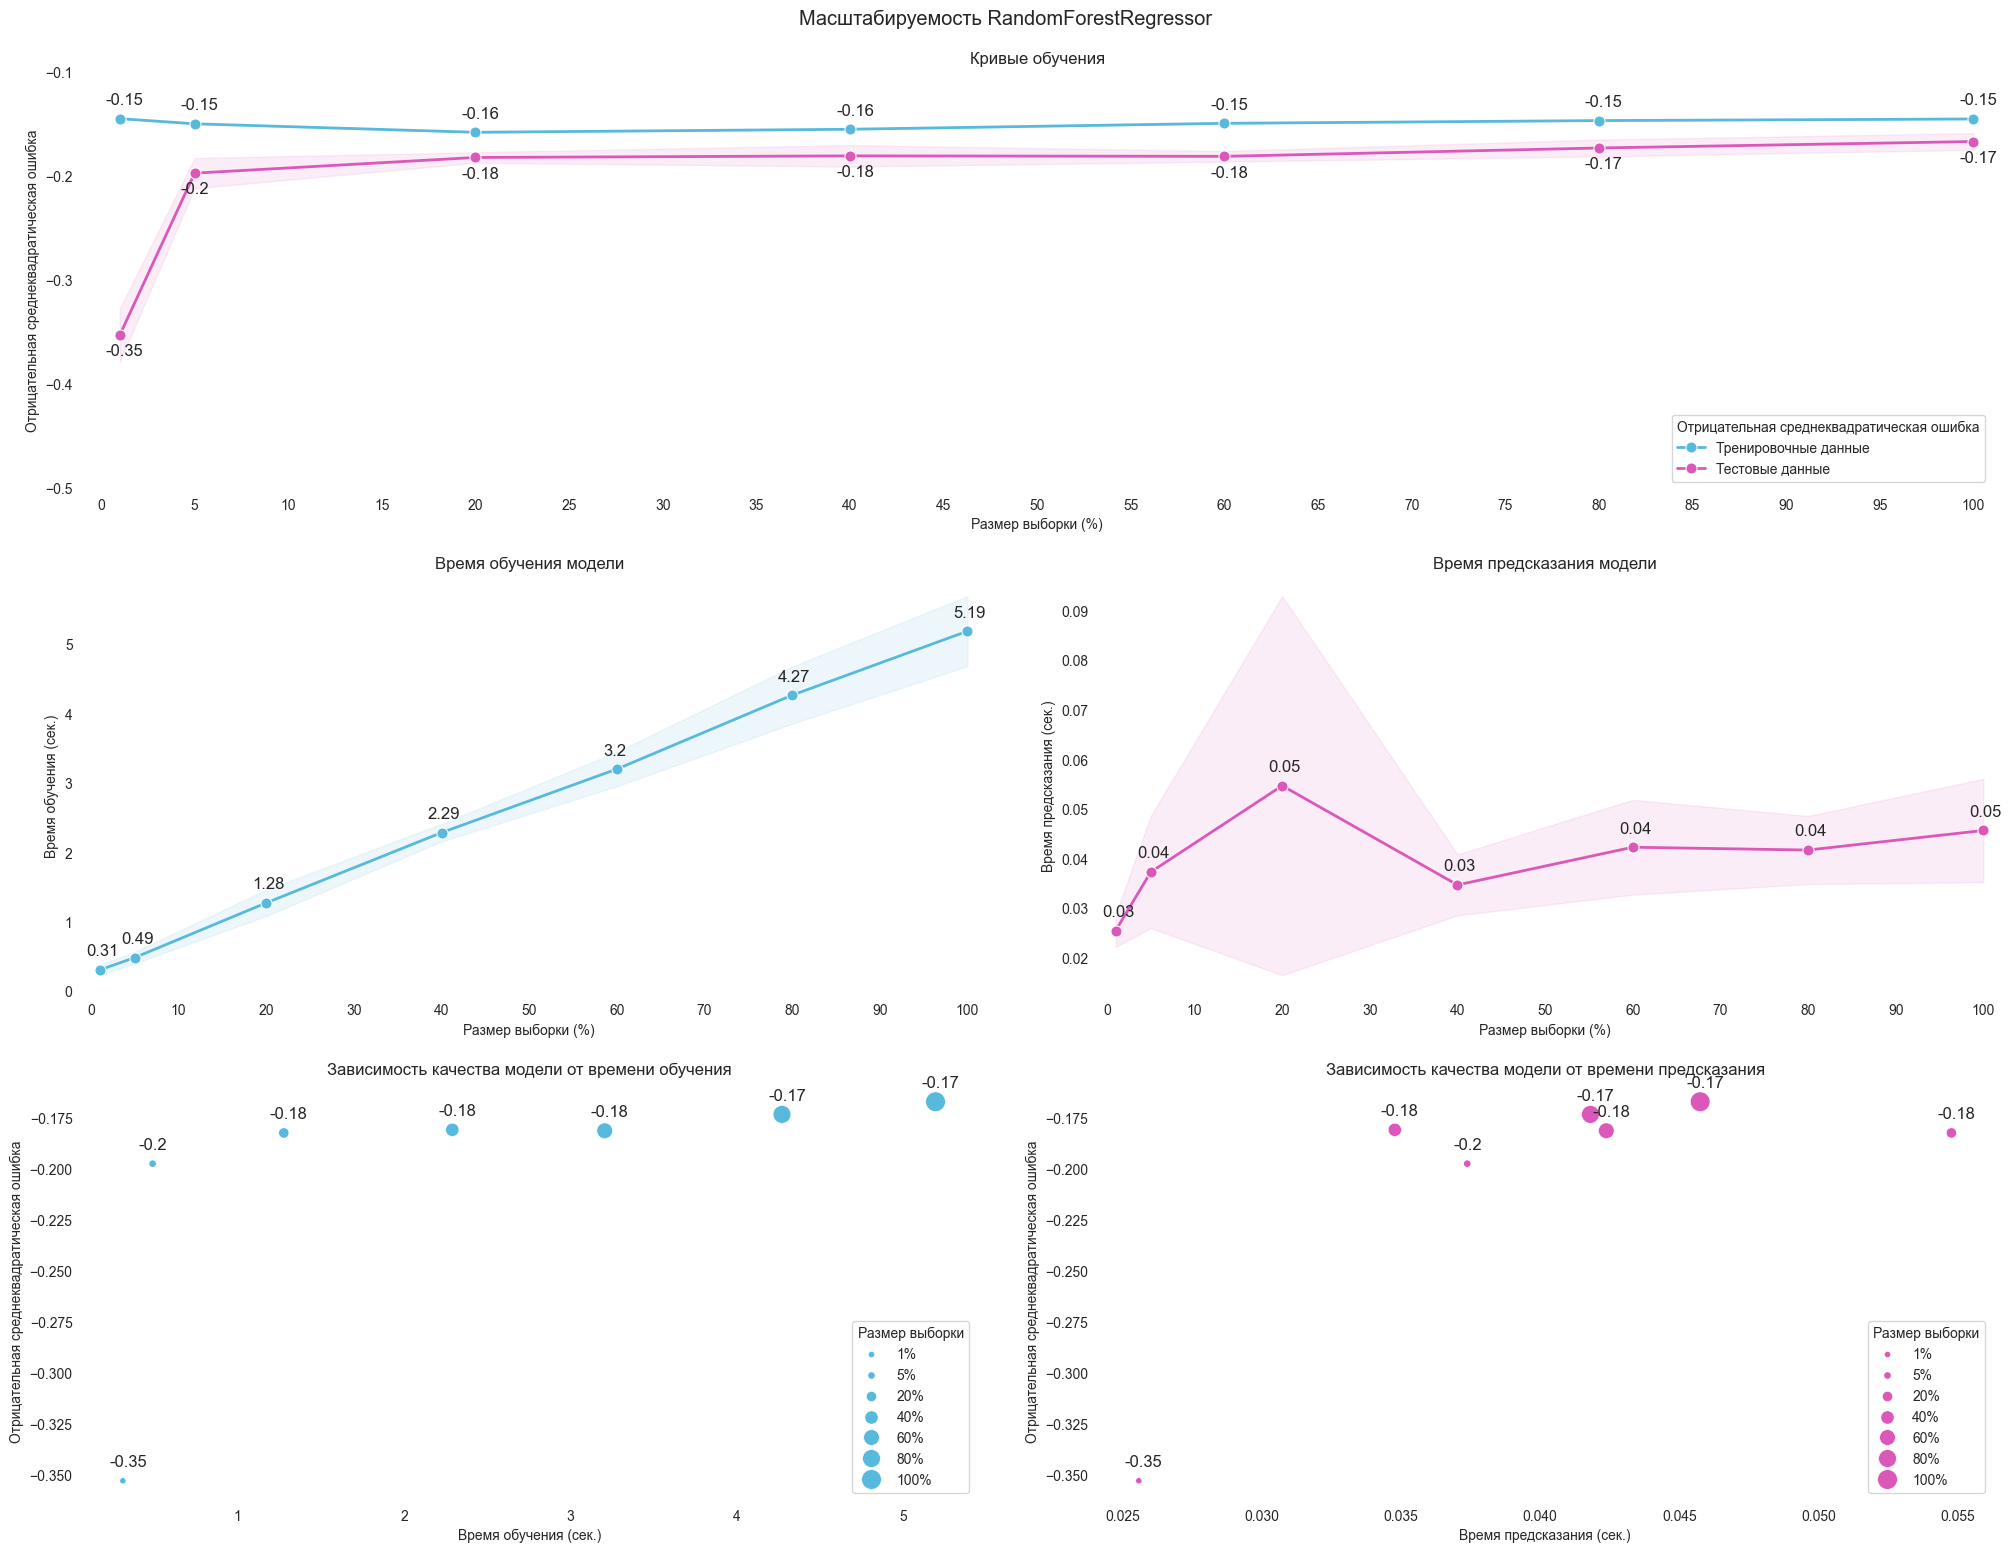

In [122]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость RandomForestRegressor'
)

In [123]:
predict = rf_rgs.predict(x_valid)

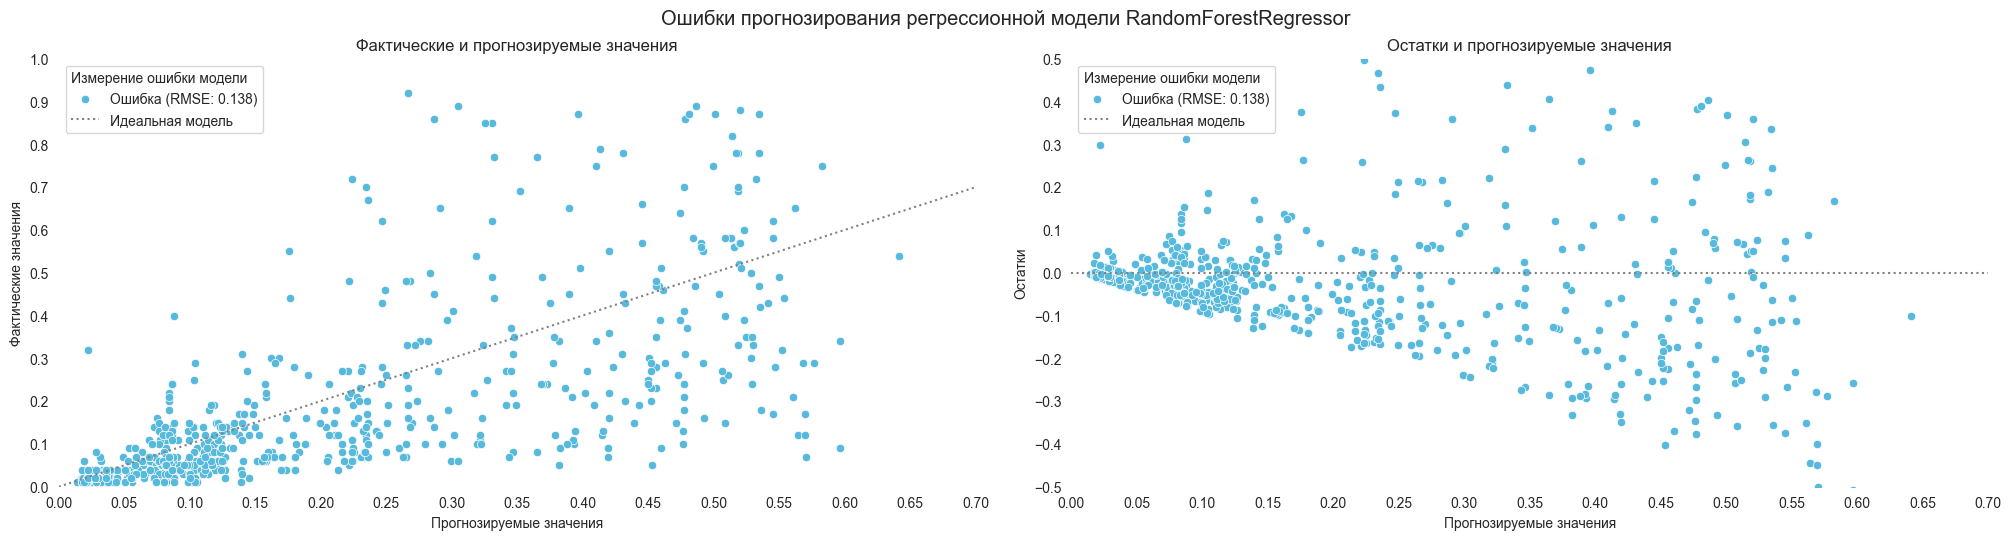

In [124]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели RandomForestRegressor'
)

### HistGradientBoostingRegressor

In [125]:
category = [
    'platform',
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other', 
    'countries', 
    'same'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other',
                                  'countries', 'same'])])

In [126]:
estimator = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan', 'other',
                                                   'countries', 'same'])])),
                ('estimator', HistGradientBoostingRegressor(random_state=42))])

In [127]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [2, 4, 6, 8],
    'estimator__max_iter': [250, 500, 1000],
    'estimator__max_leaf_nodes': [20, 30, 40, 50],
    'estimator__min_samples_leaf': [20, 30, 40, 50],
    'estimator__l2_regularization': [0.0, 0.25, 0.5, 0.75],
}

In [128]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [6],
    'estimator__max_iter': [500],
    'estimator__max_leaf_nodes': [50],
    'estimator__min_samples_leaf': [40],
    'estimator__l2_regularization': [0.25],
}

In [129]:
hgb_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

hgb_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__l2_regularization=0.25, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__max_iter=500, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=40;, score=-0.167 total time=   0.7s
[CV 2/3] END estimator__l2_regularization=0.25, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__max_iter=500, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=40;, score=-0.156 total time=   0.5s
[CV 3/3] END estimator__l2_regularization=0.25, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__max_iter=500, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=40;, score=-0.141 total time=   0.6s


In [130]:
cv_results = pd.DataFrame(
    data=hgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.681606       0.07944         0.038643        0.006179   

  param_estimator__l2_regularization param_estimator__learning_rate  \
0                               0.25                            0.1   

  param_estimator__max_depth param_estimator__max_iter  \
0                          6                       500   

  param_estimator__max_leaf_nodes param_estimator__min_samples_leaf  \
0                              50                                40   

                                              params  split0_test_score  \
0  {'estimator__l2_regularization': 0.25, 'estima...          -0.167287   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.156176          -0.141446        -0.154969        0.010584   

   rank_test_score  
0                1

In [131]:
results.loc['HistGradientBoostingRegressor', ('Со сгенерированными признаками', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['HistGradientBoostingRegressor', ('Со сгенерированными признаками', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['HistGradientBoostingRegressor', ('Со сгенерированными признаками', 'RMSE')] = cv_results.iloc[0, -3]

In [132]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=hgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    9.1s remaining:   17.6s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:   17.1s remaining:    7.8s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   25.2s finished


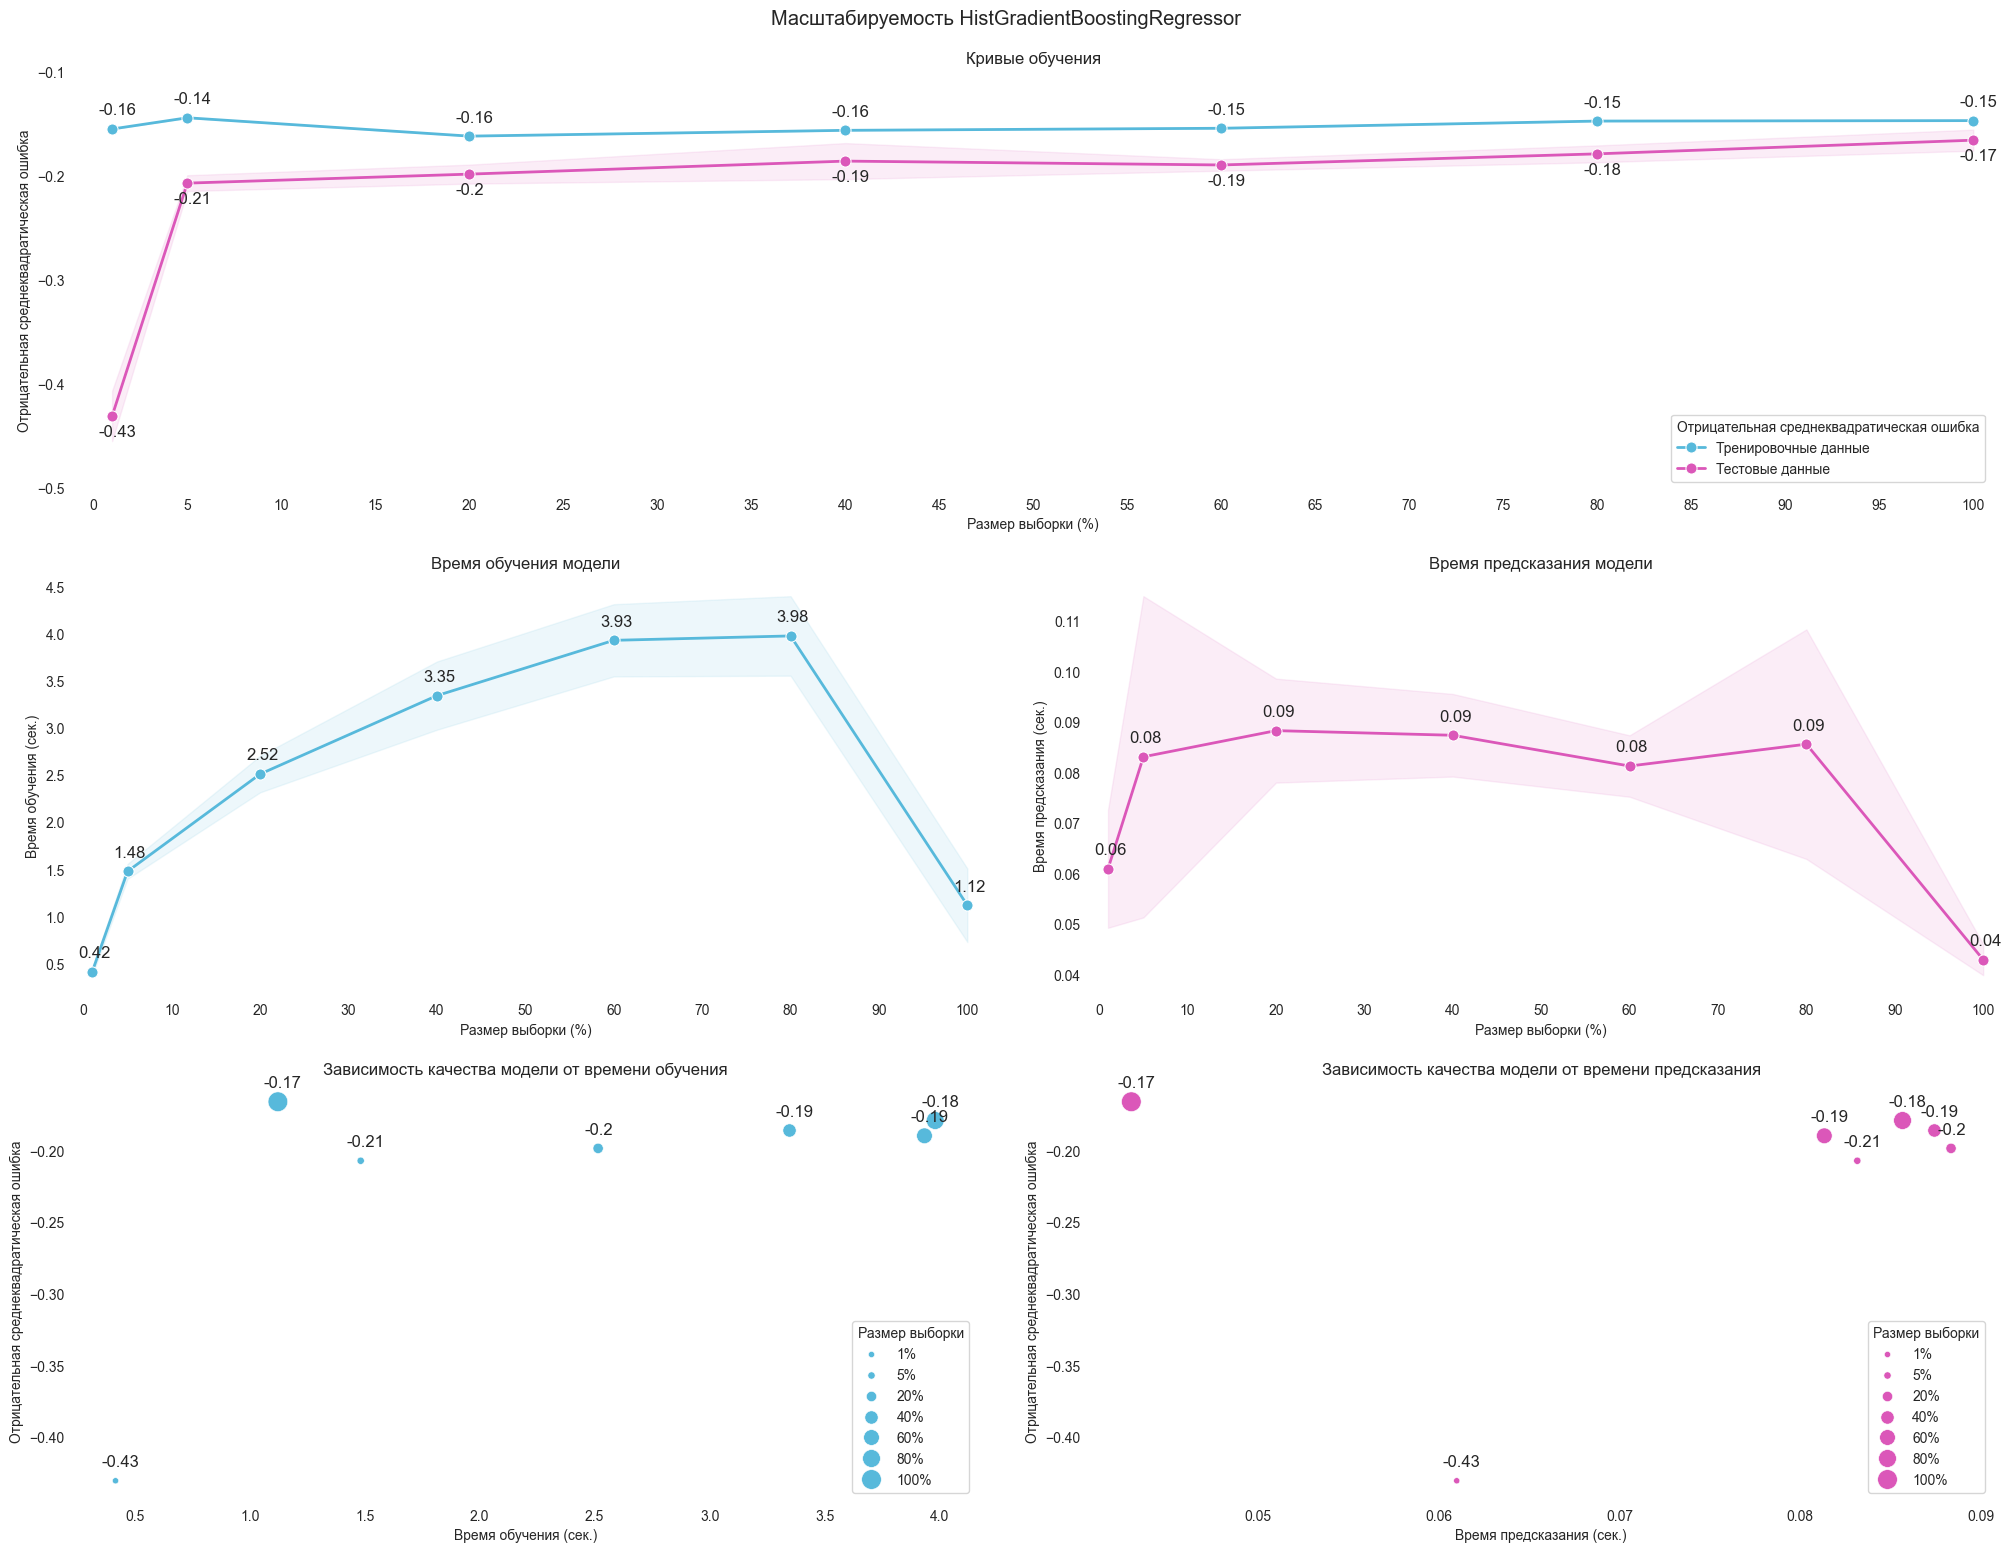

In [133]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость HistGradientBoostingRegressor'
)

In [134]:
predict = hgb_rgs.predict(x_valid)

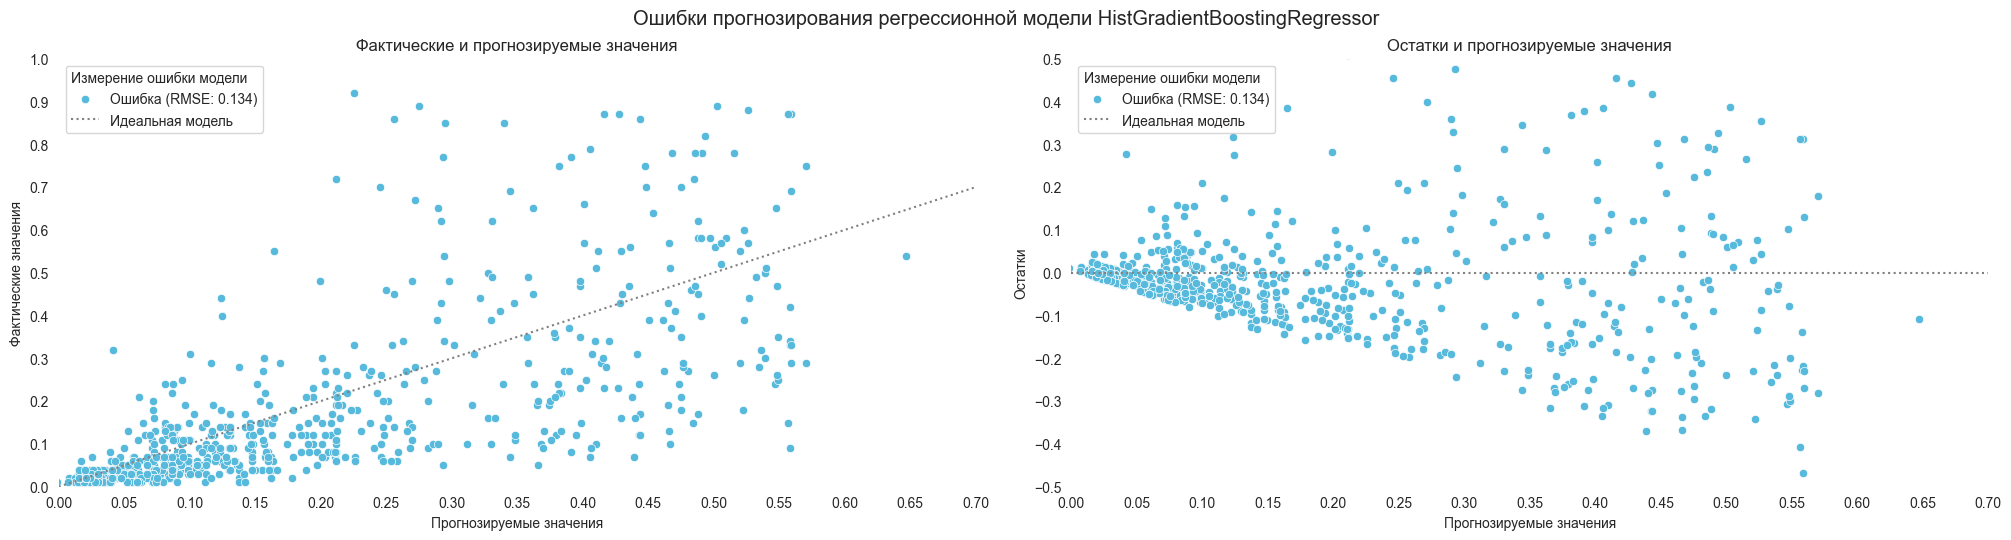

In [135]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели HistGradientBoostingRegressor'
)

### LGBMRegressor

In [136]:
category = [
    'platform',
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other', 
    'countries', 
    'same'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other',
                                  'countries', 'same'])])

In [137]:
estimator = LGBMRegressor(
    random_state=RANDOM_STATE,
    verbosity=-1
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan', 'other',
                                                   'countries', 'same'])])),
                ('estimator', LGBMRegressor(random_state=42, verbosity=-1))])

In [138]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [2, 4, 6, 8],
    'estimator__n_estimators': [250, 500, 1000],
    'estimator__num_leaves': [20, 30, 40, 50],
    'estimator__reg_alpha': [0.0, 0.25, 0.5, 0.75],
    'estimator__reg_lambda': [0.0, 0.25, 0.5, 0.75],
}

In [139]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [2],
    'estimator__n_estimators': [250],
    'estimator__num_leaves': [50],
    'estimator__reg_alpha': [0.75],
    'estimator__reg_lambda': [0.0],
}

In [140]:
lgbm_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

lgbm_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=50, estimator__reg_alpha=0.75, estimator__reg_lambda=0.0;, score=-0.168 total time=   0.2s
[CV 2/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=50, estimator__reg_alpha=0.75, estimator__reg_lambda=0.0;, score=-0.164 total time=   0.3s
[CV 3/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=50, estimator__reg_alpha=0.75, estimator__reg_lambda=0.0;, score=-0.142 total time=   0.2s


In [141]:
cv_results = pd.DataFrame(
    data=lgbm_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.267845      0.010419         0.060966        0.035673   

  param_estimator__learning_rate param_estimator__max_depth  \
0                            0.1                          2   

  param_estimator__n_estimators param_estimator__num_leaves  \
0                           250                          50   

  param_estimator__reg_alpha param_estimator__reg_lambda  \
0                       0.75                         0.0   

                                              params  split0_test_score  \
0  {'estimator__learning_rate': 0.1, 'estimator__...          -0.167877   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           -0.16407          -0.141778        -0.157908        0.011511   

   rank_test_score  
0                1

In [142]:
results.loc['LGBMRegressor', ('Со сгенерированными признаками', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['LGBMRegressor', ('Со сгенерированными признаками', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['LGBMRegressor', ('Со сгенерированными признаками', 'RMSE')] = cv_results.iloc[0, -3]

In [143]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=lgbm_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    2.8s remaining:    5.4s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    6.9s finished


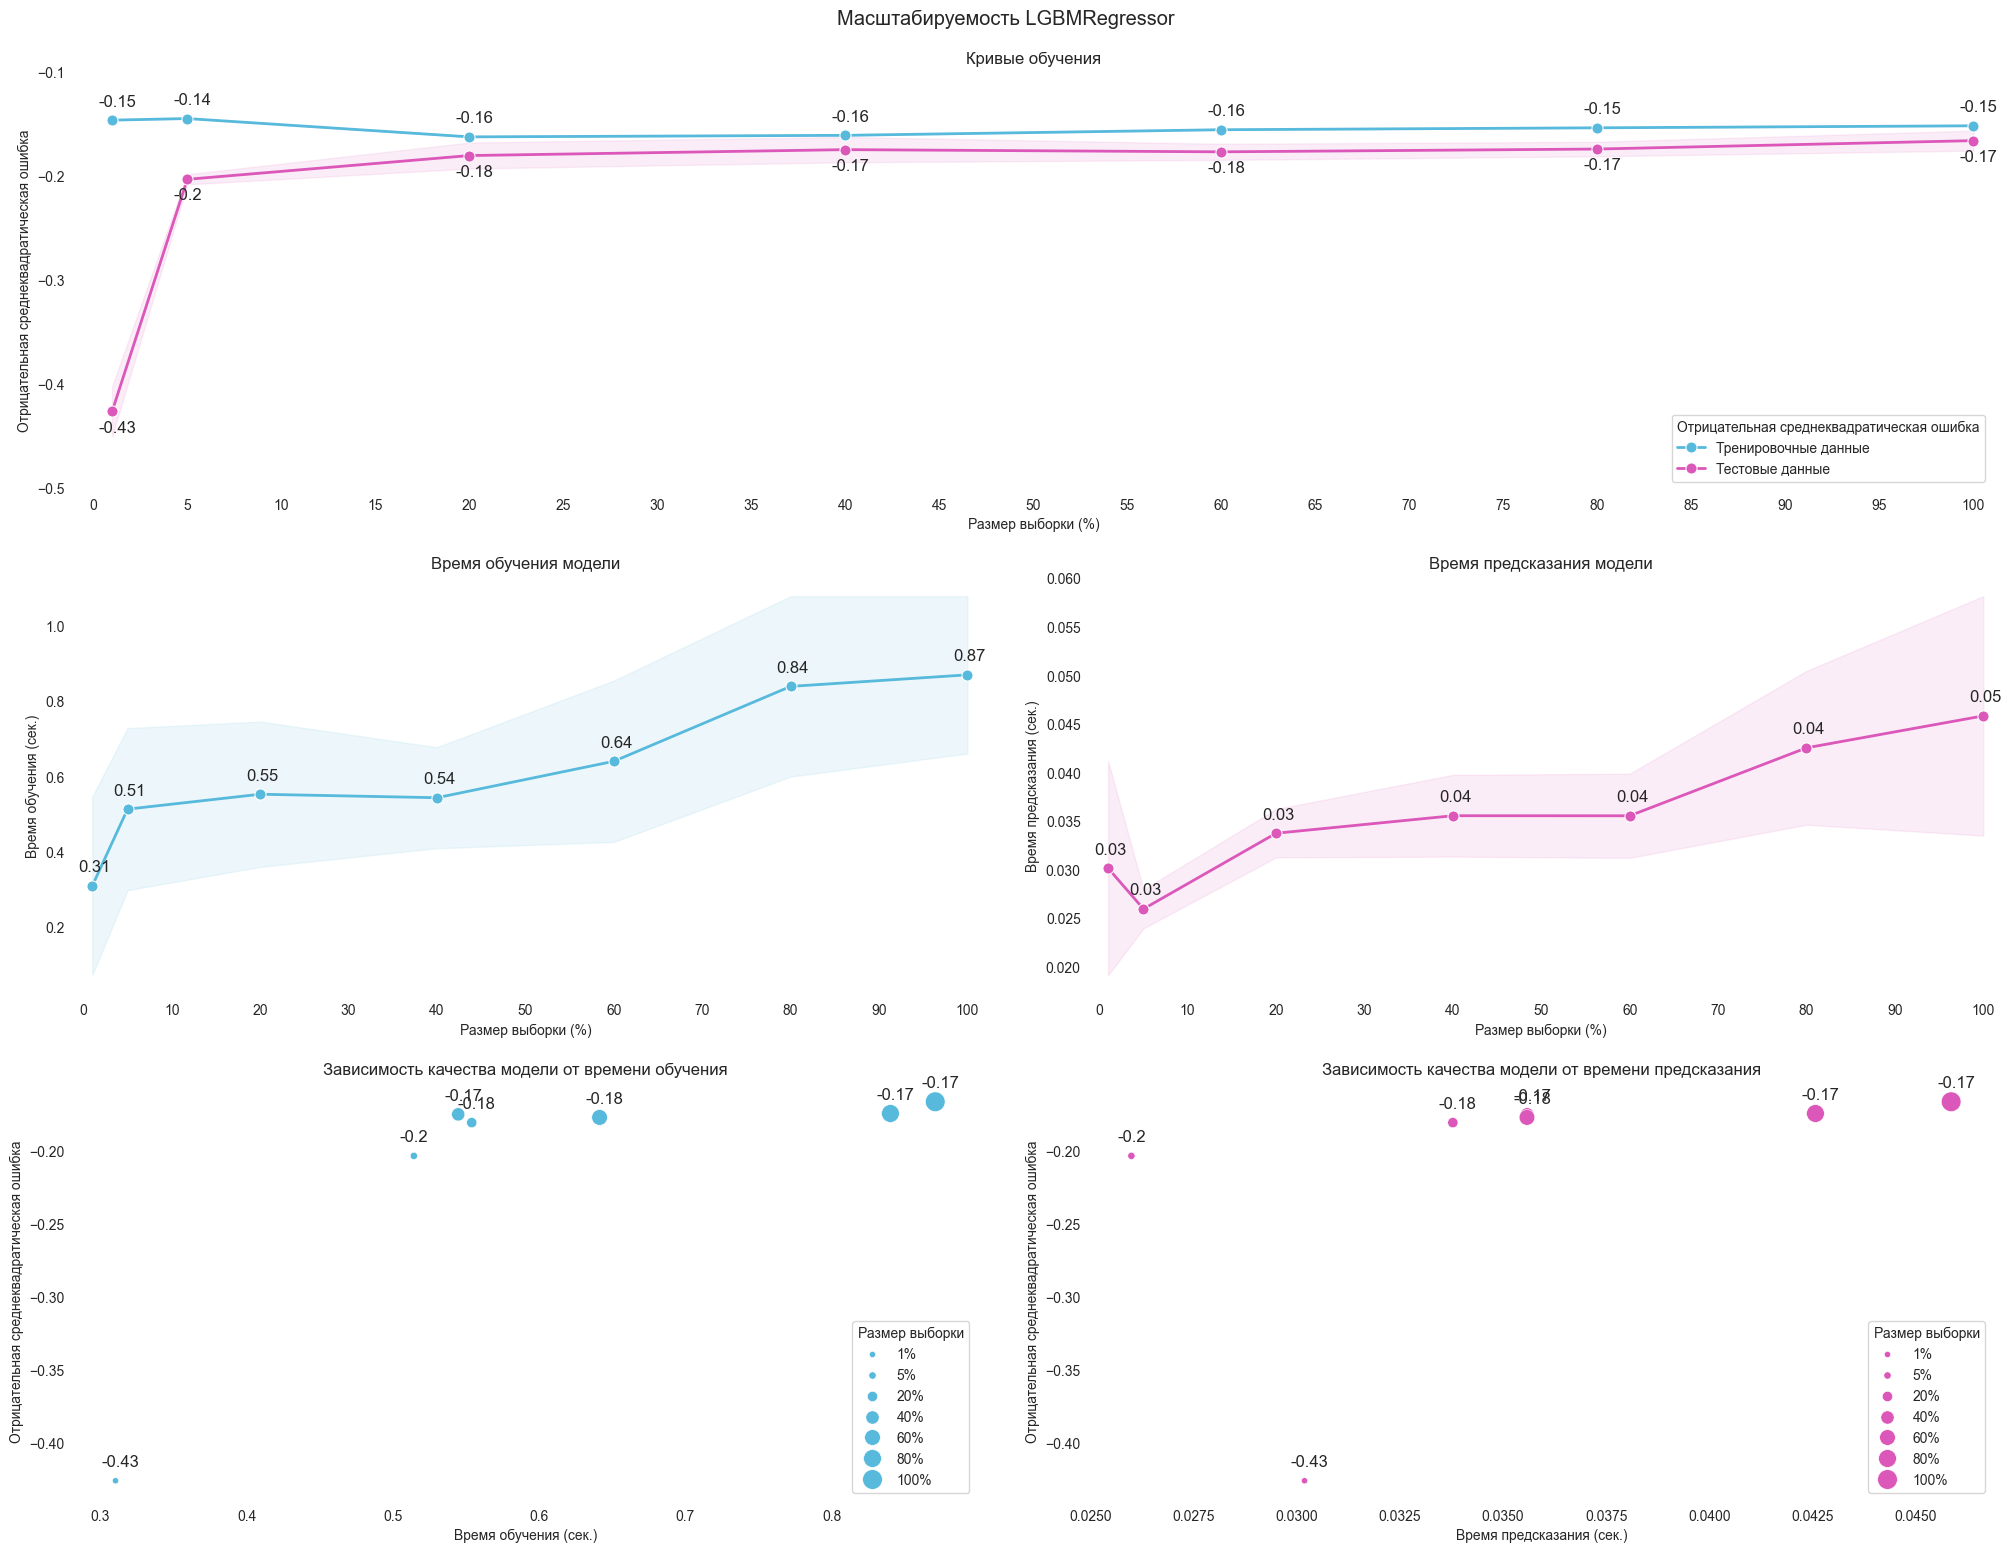

In [144]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость LGBMRegressor'
)

In [145]:
predict = lgbm_rgs.predict(x_valid)

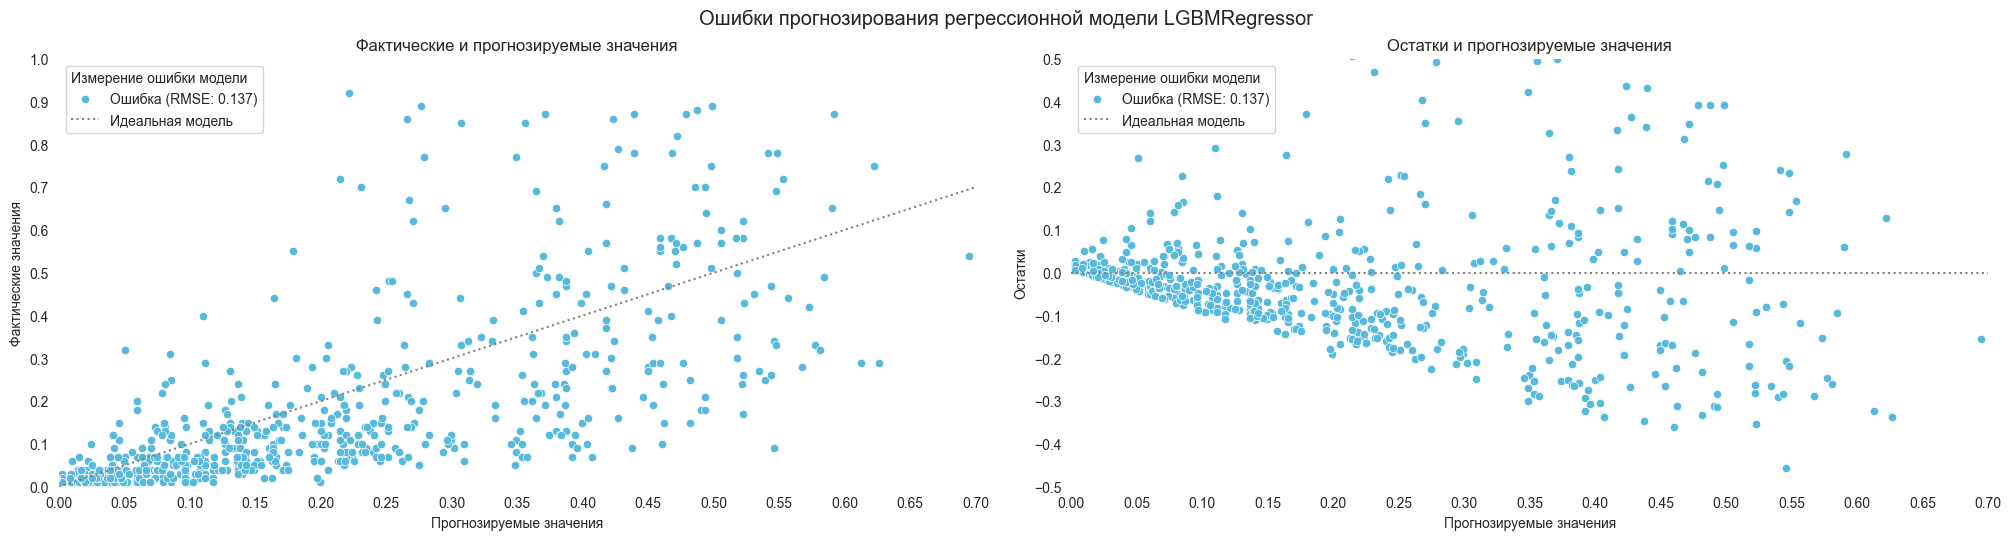

In [146]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели LGBMRegressor'
)

### XGBRegressor

In [147]:
category = [
    'platform',
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other', 
    'countries', 
    'same'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other',
                                  'countries', 'same'])])

In [148]:
estimator = XGBRegressor(
    random_state=RANDOM_STATE,
    verbosity=0
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan', 'other',
                                                   'countries', 'same'])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [149]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [2, 4, 6, 8],
    'estimator__n_estimators': [250, 500, 1000],
    'estimator__max_leaves': [20, 30, 40, 50],
    'estimator__reg_alpha': [0.0, 0.25, 0.5, 0.75],
    'estimator__reg_lambda': [0.0, 0.25, 0.5, 0.75],
}

In [150]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [2],
    'estimator__n_estimators': [250],
    'estimator__max_leaves': [50],
    'estimator__reg_alpha': [0.5],
    'estimator__reg_lambda': [0.25],
}

In [151]:
xgb_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

xgb_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=50, estimator__n_estimators=250, estimator__reg_alpha=0.5, estimator__reg_lambda=0.25;, score=-0.167 total time=   0.5s
[CV 2/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=50, estimator__n_estimators=250, estimator__reg_alpha=0.5, estimator__reg_lambda=0.25;, score=-0.164 total time=   0.3s
[CV 3/3] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=50, estimator__n_estimators=250, estimator__reg_alpha=0.5, estimator__reg_lambda=0.25;, score=-0.141 total time=   0.3s


In [152]:
cv_results = pd.DataFrame(
    data=xgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.447077       0.08132         0.041641        0.001883   

  param_estimator__learning_rate param_estimator__max_depth  \
0                            0.1                          2   

  param_estimator__max_leaves param_estimator__n_estimators  \
0                          50                           250   

  param_estimator__reg_alpha param_estimator__reg_lambda  \
0                        0.5                        0.25   

                                              params  split0_test_score  \
0  {'estimator__learning_rate': 0.1, 'estimator__...          -0.167357   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.164111          -0.141135        -0.157534        0.011672   

   rank_test_score  
0                1

In [153]:
results.loc['XGBRegressor', ('Со сгенерированными признаками', 'Время обучения')] = cv_results.iloc[0, 0]
results.loc['XGBRegressor', ('Со сгенерированными признаками', 'Время предсказания')] = cv_results.iloc[0, 2]
results.loc['XGBRegressor', ('Со сгенерированными признаками', 'RMSE')] = cv_results.iloc[0, -3]

In [154]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=xgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=TimeSeriesSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE
    ),
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  114   573  2294  4589  6884  9179 11474]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:    1.5s remaining:    2.9s
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:    2.6s remaining:    1.1s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    4.1s finished


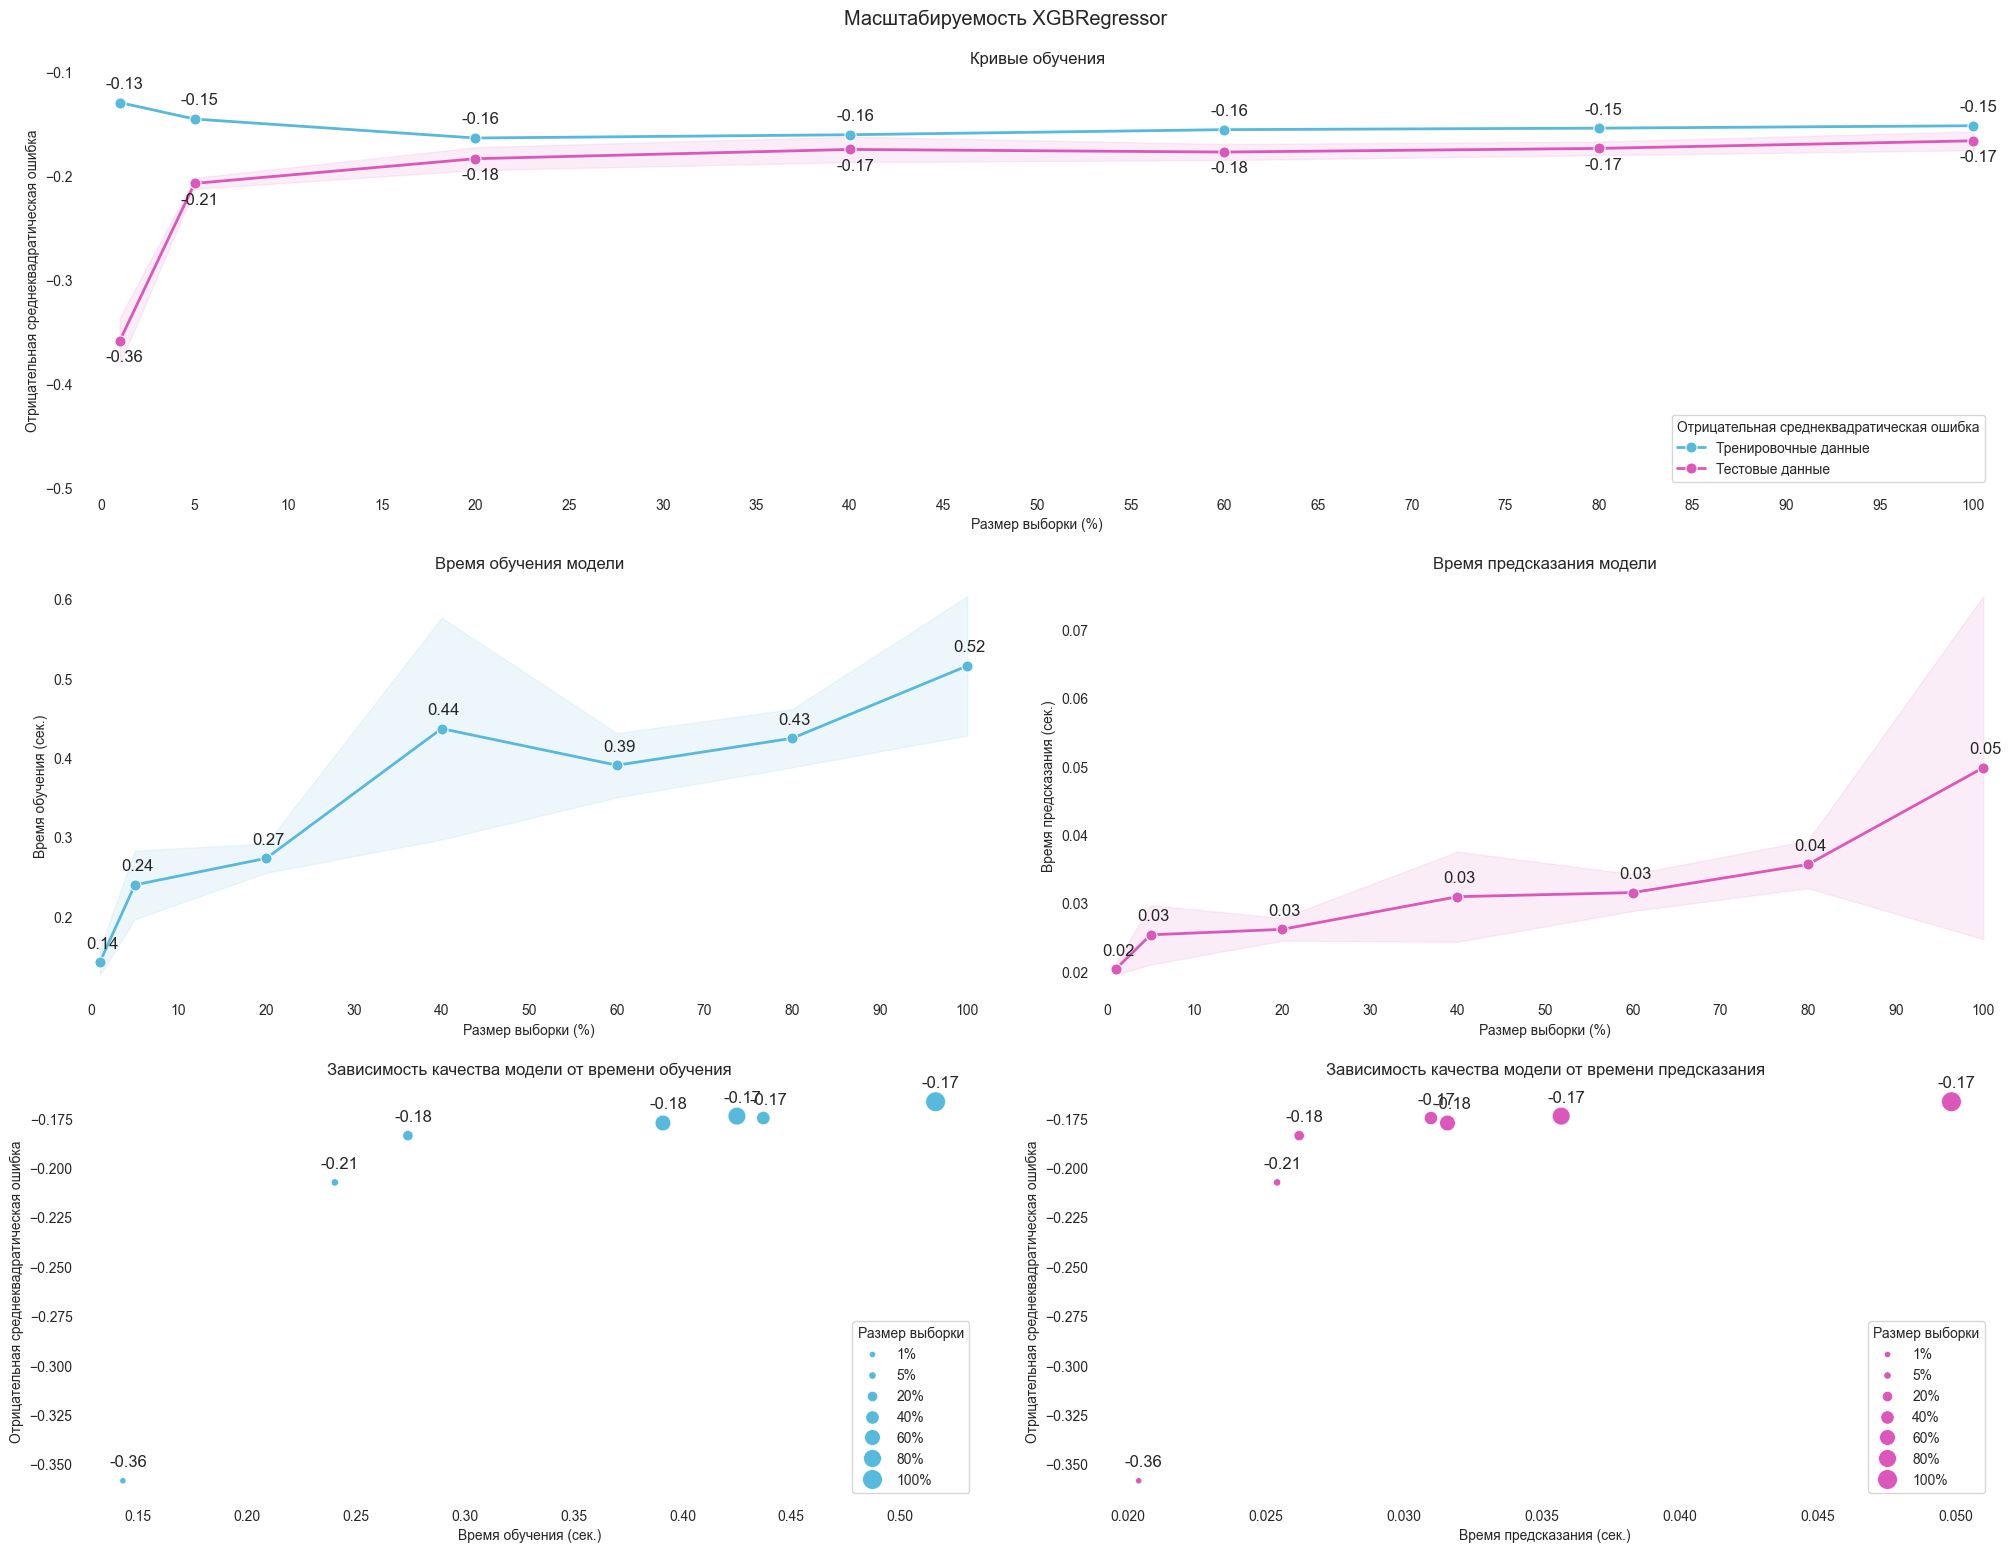

In [155]:
x_train_size = x_train.shape[0] 
x_train_size -= LEARNING_CURVE_TEST_SIZE * LEARNING_CURVE_N_SPLITS
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость XGBRegressor'
)

In [156]:
predict = xgb_rgs.predict(x_valid)

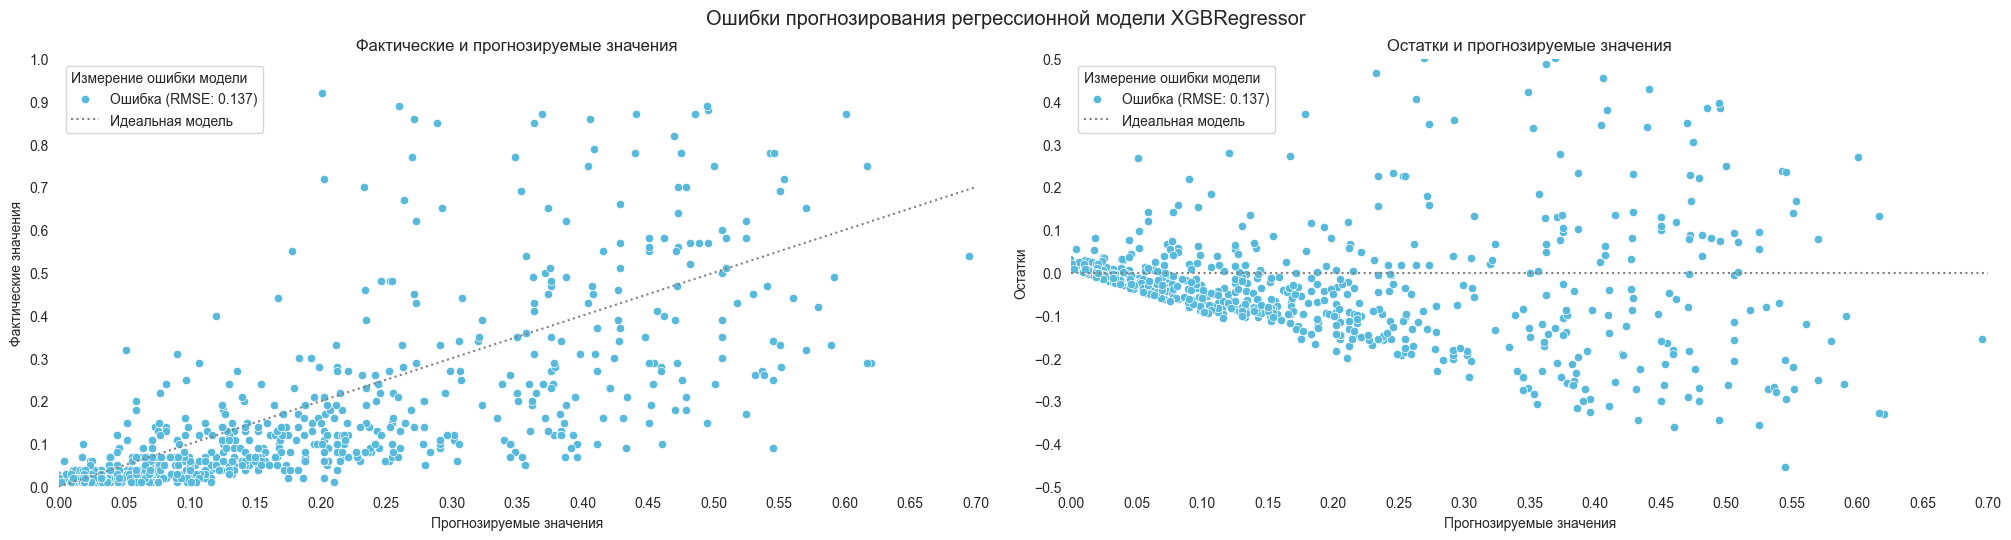

In [157]:
error.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели XGBRegressor'
)

### Выводы по генерации признаков

In [158]:
results.style.format(na_rep='-')

1. Были сгенерированы следующие признаки:
    - количество стран, в которых осуществлялась продажа видеоигры;
    - является ли разработчик и издатель одной компанией.
2. DecisionTreeRegressor:
    - среднее время обучения: до **0.15** сек.;
    - среднее время предсказания: до **0.03** сек.;
    - среднее значение RMSE: **0.161**;
    - значение RMSE на валидационной выборке: **0.138**.
3. RandomForestRegressor:
    - среднее время обучения: до **4.35** сек.;
    - среднее время предсказания: до **0.04** сек.;
    - среднее значение RMSE: **0.157**;
    - значение RMSE на валидационной выборке: **0.138**.
4. HistGradientBoostingRegressor:
    - среднее время обучения: до **0.63** сек.;
    - среднее время предсказания: до **0.03** сек.;
    - среднее значение RMSE: **0.155**;
    - значение RMSE на валидационной выборке: **0.134**.
5. LGBMRegressor:
    - среднее время обучения: до **0.32** сек.;
    - среднее время предсказания: до **0.05** сек.;
    - среднее значение RMSE: **0.158**;
    - значение RMSE на валидационной выборке: **0.137**.
6. XGBRegressor:
    - среднее время обучения: до **0.42** сек.;
    - среднее время предсказания: до **0.04** сек.;
    - среднее значение RMSE: **0.157**;
    - значение RMSE на валидационной выборке: **0.137**.

## Проверка модели на тестовой выборке

In [159]:
x = pd.concat([x_train, x_valid])
x

date platform            publisher                  developer  america  \
0      1970       PC            505 Games              BiArt Studios    False   
1      1970       PC  Paradox Interactive  Most Wanted Entertainment    False   
2      1977     2600                Atari                      Atari     True   
3      1977     2600                Atari                      Atari     True   
4      1978     2600                Atari                      Atari     True   
...     ...      ...                  ...                        ...      ...   
14745  2017      3DS             Nintendo                Omega Force     True   
14746  2017       NS             Nintendo                Omega Force     True   
14747  2017       NS             Microids                   Microids    False   
14748  2017       PC           Activision                     Bungie     True   
14749  2017     XOne        Kalypso Media              Studio Fizbin     True   

       europe  japan  other  countries   same  
0       False  False  False          0  False  
1        True  False  False          1  False  
2        True  False   True          3   True  
3        True  False  False          2   True  
4        True  False  False          2   True  
...       ...    ...    ...        ...    ...  
14745    True   True   True          4  False  
14746    True   True   True          4  False  
14747    True  False  False          1   True  
14748    True  False   True          3  False  
14749   False  False  False          1  False  

[14750 rows x 10 columns]

In [160]:
y = pd.concat([y_train, y_valid])
y

0        0.01
1        0.01
2        0.98
3        0.27
4        0.44
         ... 
14745    0.15
14746    0.51
14747    0.02
14748    0.16
14749    0.02
Name: total, Length: 14750, dtype: float32

In [161]:
category = [
    'platform',
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other', 
    'countries', 
    'same'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other',
                                  'countries', 'same'])])

In [162]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan', 'other',
                                                   'countries', 'same'])])),
                ('estimator', RandomForestRegressor(random_state=42))])

In [163]:
best_param = {
    'estimator__max_depth': [11],
    'estimator__min_samples_split': [4],
    'estimator__min_samples_leaf': [7]
}

In [164]:
rf_rgs = GridSearchCV(
    estimator=model,
    cv=TimeSeriesSplit(
        n_splits=FIT_CV_N_SPLITS,
        test_size=FIT_CV_TEST_SIZE
    ),
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=FIT_CV_VERBOSE
)

rf_rgs.fit(x_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__max_depth=11, estimator__min_samples_leaf=7, estimator__min_samples_split=4;, score=-0.165 total time=   4.4s
[CV 2/3] END estimator__max_depth=11, estimator__min_samples_leaf=7, estimator__min_samples_split=4;, score=-0.159 total time=   4.9s
[CV 3/3] END estimator__max_depth=11, estimator__min_samples_leaf=7, estimator__min_samples_split=4;, score=-0.147 total time=   5.1s


In [165]:
x_test = generate(x_test)
x_test

date platform                       publisher                developer  \
14750  2017      PS4          GameMill Entertainment                 GameMill   
14751  2017     WiiU                         Ubisoft            Ubisoft Paris   
14752  2017      PSV                     NIS America     Nippon Ichi Software   
14753  2017      PS4  Sony Interactive Entertainment              Wish Studio   
14754  2017      PS4                        GameMill  Concrete Software, Inc.   
...     ...      ...                             ...                      ...   
15522  2020      PS4                     NIS America                   Falcom   
15523  2020      PS3     Sony Computer Entertainment    PlayStation C.A.M.P.!   
15524  2020       DS                         Ubisoft   Global A Entertainment   
15525  2020      PS4                          GungHo  Grasshopper Manufacture   
15526  2020      3DS              Namco Bandai Games       Namco Bandai Games   

       america  europe  japan  other  countries   same  
14750     True   False  False   True          2  False  
14751     True    True  False   True          3  False  
14752    False   False   True  False          1  False  
14753     True    True  False   True          3  False  
14754     True   False  False   True          2  False  
...        ...     ...    ...    ...        ...    ...  
15522    False   False   True  False          1  False  
15523    False   False   True  False          1  False  
15524     True   False  False   True          2  False  
15525    False    True   True  False          2  False  
15526    False   False   True  False          1   True  

[777 rows x 10 columns]

In [166]:
predict = rf_rgs.predict(x_test)

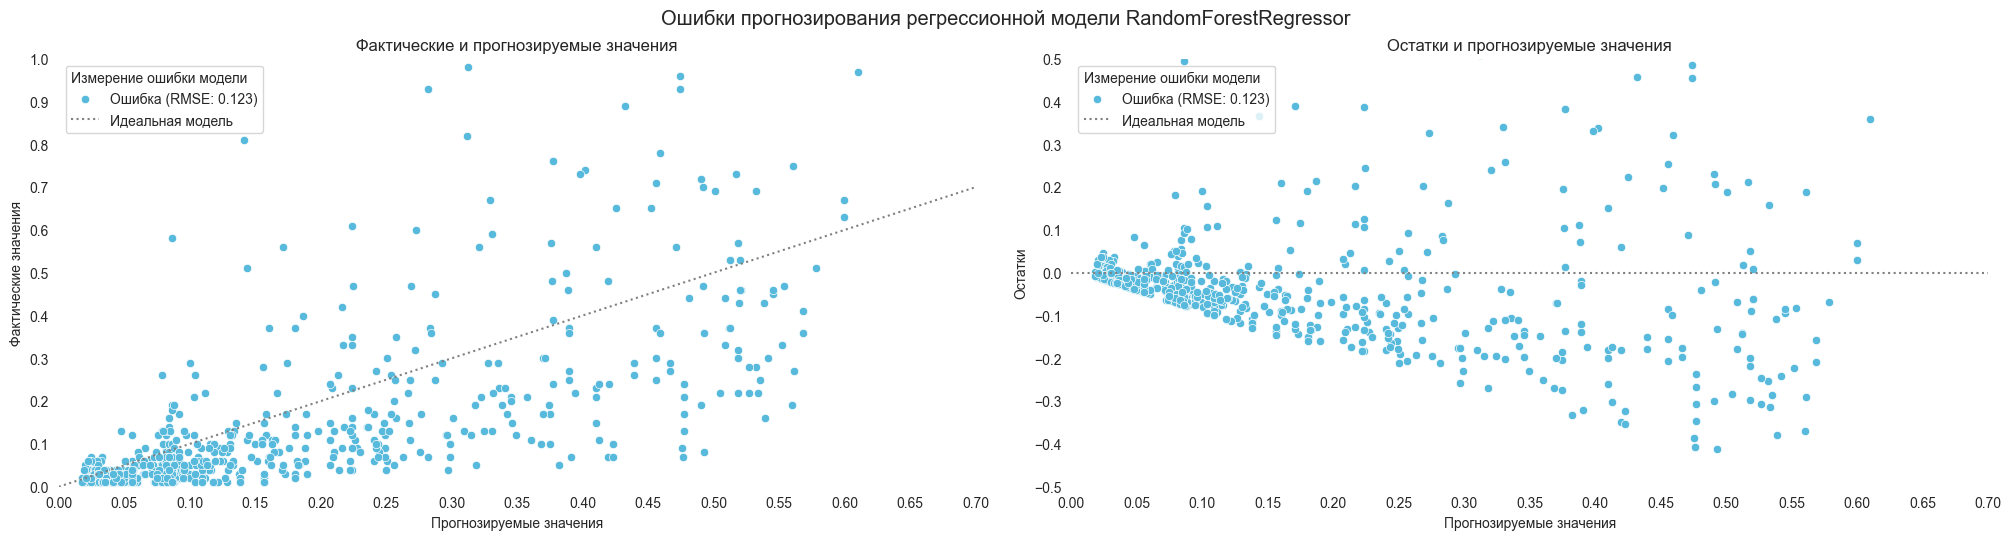

In [167]:
error.error(
    y_true=pd.Series(y_test), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели RandomForestRegressor'
)

## Сравнение с фиктивным регрессором

In [168]:
dummy_rgs = DummyRegressor(strategy="mean")
dummy_rgs

DummyRegressor()

In [169]:
dummy_rgs.fit(x, y)

DummyRegressor()

In [170]:
predict = dummy_rgs.predict(x_test)

In [171]:
root_mean_squared_error(y_test, predict)

0.19427745

# Выводы

1. Отбор данных:
    - в качестве целевого признака был выбран признак **total**.
    - в качестве независимых признаков были выбраны:
        - date;
        - platform;
        - publisher;
        - developer;
        - america;
        - europe;
        - japan;
        - other.
    - были выбраны записи, в которых в поле **total** значения **не превышали 1.0**.
2. Преобразование данных:
    - для поля **date** был оставлен только год выпуска видеоигры;
    - для полей **america**, **europe**, **japan**, **other** значение было заменено на **True** и **False**, чтобы предотвратить **утечки целевого признака**.
3. Данные были разделены на **тренировочную**, **валидационную** и **тестовую** выборки в отношении **0.5:0.5:9**.
4. Тестирование моделей:
    - Для кодирования признаков использован **TargetEncoder**.
    - Дляля оценки эффективности **предсказательной способности** модели использована метрика **RMSE**.
    - Для **оценки эффективности** были выбраны следующие показатели:
        - время обучения;
        - время предсказания;
        - RMSE.
    1. DecisionTreeRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.5** сек.;
            - среднее время предсказания: до **0.02** сек.;
            - среднее значение RMSE: **0.165**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.146**;
            - **присутствует гетероскедастичность** остатков.
    2. RandomForestRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **4.0** сек.;
            - среднее время предсказания: до **0.035** сек.;
            - среднее значение RMSE: **0.158**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.139**;
            - **присутствует гетероскедастичность** остатков.
    3. HistGradientBoostingRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.6** сек.;
            - среднее время предсказания: до **0.03** сек.;
            - среднее значение RMSE: **0.133**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.157**;
            - **присутствует гетероскедастичность** остатков.
    4. LGBMRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.35** сек.;
            - среднее время предсказания: до **0.035** сек.;
            - среднее значение RMSE: **0.158**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.133**;
            - **присутствует гетероскедастичность** остатков.
    5. XGBRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.35** сек.;
            - среднее время предсказания: до **0.035** сек.;
            - среднее значение RMSE: **0.160**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.136**;
            - **присутствует гетероскедастичность** остатков.
5. Генерация признков:
    - Были сгенерированы следующие признаки:
        - количество стран, в которых осуществлялась продажа видеоигры;
        - является ли разработчик и издатель одной компанией.
    1. DecisionTreeRegressor:
        - среднее время обучения: до **0.15** сек.;
        - среднее время предсказания: до **0.03** сек.;
        - среднее значение RMSE: **0.161**;
        - значение RMSE на валидационной выборке: **0.138**.
    2. RandomForestRegressor:
        - среднее время обучения: до **4.35** сек.;
        - среднее время предсказания: до **0.04** сек.;
        - среднее значение RMSE: **0.157**;
        - значение RMSE на валидационной выборке: **0.138**.
    3. HistGradientBoostingRegressor:
        - среднее время обучения: до **0.63** сек.;
        - среднее время предсказания: до **0.03** сек.;
        - среднее значение RMSE: **0.155**;
        - значение RMSE на валидационной выборке: **0.134**.
    4. LGBMRegressor:
        - среднее время обучения: до **0.32** сек.;
        - среднее время предсказания: до **0.05** сек.;
        - среднее значение RMSE: **0.158**;
        - значение RMSE на валидационной выборке: **0.137**.
    5. XGBRegressor:
        - среднее время обучения: до **0.42** сек.;
        - среднее время предсказания: до **0.04** сек.;
        - среднее значение RMSE: **0.157**;
        - значение RMSE на валидационной выборке: **0.137**.
6. Проверка модели на тестовой выборке:
    - в качестве итоговой модели была выбрана модель **RandomForestRegressor**;
    - значение RMSE на тестовой выборе было равно **0.123**.
7. Сравнение с фиктивным регрессором:
    - в качестве фиктивного регресора был выбран **DummyRegressor** со стратегией **mean**;
    - значение RMSE на тестовой выборе для фиктивного регрессора было равно **0.194**.